## Practice: Image Classification

## PathMNIST Image Classification Benchmark (SVM, MLP, CNN)


## Setup and dependencies

In [ ]:
# Installation
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.8 MB/s eta 0:00:00


In [ ]:
# Import modules
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import keras_tuner as kt
from keras_tuner import RandomSearch
import time
import random
import pandas as pd
from functools import partial
import math
from itertools import product
import matplotlib.pyplot as plt

## 1. Data loading, exploration, and preprocessing


In [ ]:
# Load the dataset training and test sets as numpy arrays
# as the notebook
X_train = np.load('/X_train.npy')
y_train = np.load('/y_train.npy')
X_test = np.load('/X_test.npy')
y_test = np.load('/y_test.npy')

In [ ]:
# Explore the data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print()
# Check value range
print(X_train.dtype)
print(X_test.dtype)

# Check number of classes
print(np.unique(y_train))
print(np.unique(y_test))

(32000, 28, 28, 3)
(8000, 28, 28, 3)
(32000,)
(8000,)

uint8
uint8
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


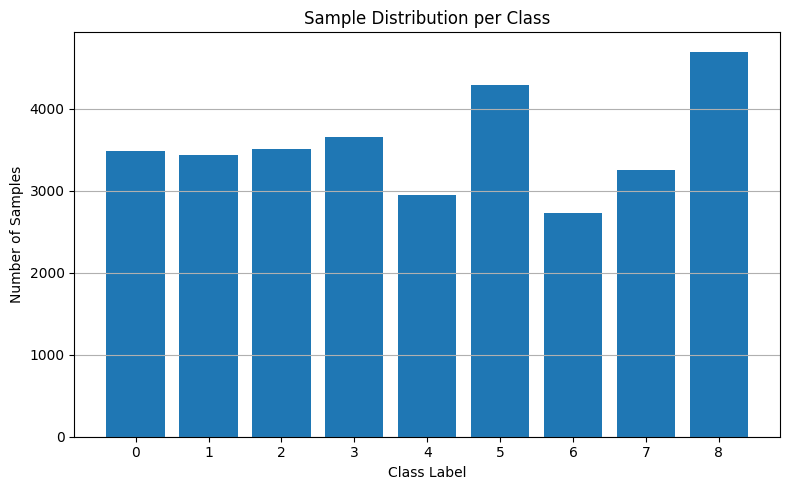

In [ ]:
# Visualize sample distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique, counts, tick_label=unique)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Sample Distribution per Class")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

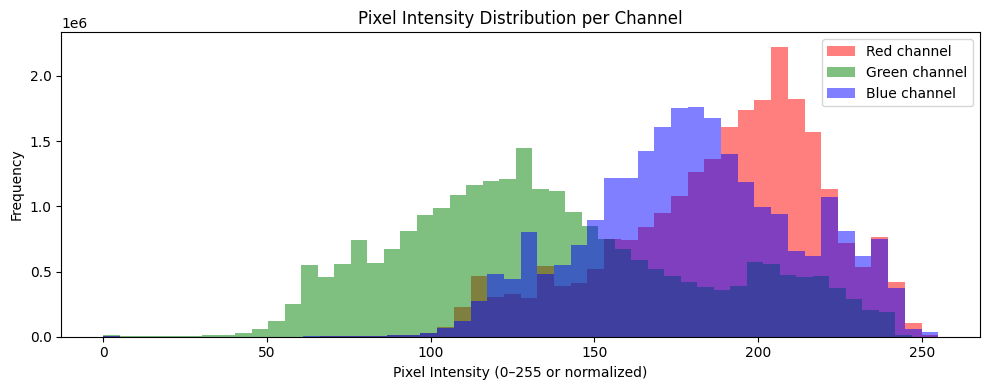

Red channel - Mean: 188.65, Std: 31.91
Green channel - Mean: 135.93, Std: 45.60
Blue channel - Mean: 180.05, Std: 32.18


In [ ]:
# Visualize pixel intensities
red_channel = X_train[:, :, :, 0].flatten()
green_channel = X_train[:, :, :, 1].flatten()
blue_channel = X_train[:, :, :, 2].flatten()
plt.figure(figsize=(10, 4))
plt.hist(red_channel, bins=50, color='red', alpha=0.5, label='Red channel')
plt.hist(green_channel, bins=50, color='green', alpha=0.5, label='Green channel')
plt.hist(blue_channel, bins=50, color='blue', alpha=0.5, label='Blue channel')
plt.xlabel("Pixel Intensity (0–255 or normalized)")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution per Channel")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print the mean and standard deviation of each channel
for i, name in enumerate(['Red', 'Green', 'Blue']):
  channel = X_train[:, :, :, i]
  print(f"{name} channel - Mean: {channel.mean():.2f}, Std: {channel.std():.2f}")


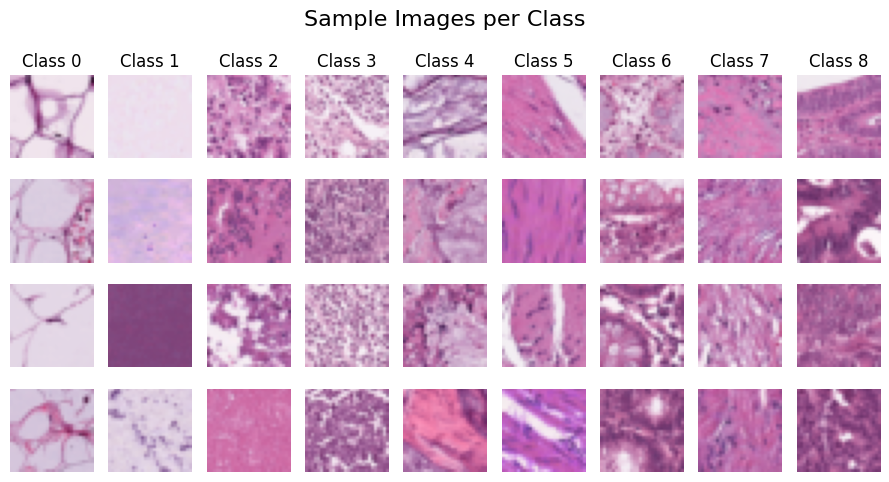

In [ ]:
# Get the unique class labels
classes = np.unique(y_train)
num_classes = len(classes)
samples_per_class = 4

# Print samples for each class
plt.figure(figsize=(num_classes, 5))
for col, cls in enumerate(classes):
  idxs = np.where(y_train == cls)[0][:samples_per_class]
  for row, idx in enumerate(idxs):
    plt.subplot(
      samples_per_class,
      num_classes, row * num_classes + col + 1
    )
    plt.imshow(X_train[idx])
    if row == 0:
      plt.title(f"Class {cls}")
    plt.axis('off')
plt.suptitle("Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Preprocessing
# Min-Max Scaling
X_train = X_train / 255.0
X_test = X_test / 255.0

# Creating a validation set
X_train, X_valid, y_train, y_valid = train_test_split(
  X_train, y_train, train_size=0.9
)

# Flatten data for SVM
X_train_flat = X_train.reshape(len(X_train), -1)
X_valid_flat = X_valid.reshape(len(X_valid), -1)
X_test_flat = X_test.reshape(len(X_test), -1)


#### Principal Component Analysis

In [ ]:
# PCA
start = time.time()
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_flat)
X_valid_reduced  = pca.transform(X_valid_flat)
X_test_reduced  = pca.transform(X_test_flat)
duration = time.time() - start
print(f"{duration:.2f}")

73.70


### Examples of preprocessed data

In [ ]:
# Print examples and data shape
# of preprocessed data
for i in range(10):
  print(X_train[0][0][i])
print(X_train.shape, X_valid.shape, X_test.shape)

print()
for i in range(10):
  print(X_train_flat[0][i])
print(X_train_flat.shape, X_valid_flat.shape, X_test_flat.shape)

print()
for i in range(10):
  print(y_train[i])
print(y_train.shape, y_valid.shape, y_test.shape)

print()
for i in range(10):
  print(X_train_reduced[0][i])
print(f"Shape of original training data: {str(X_train_flat.shape)}")
print(f"Shape of reduced training data: {str(X_train_reduced.shape)}")


[0.81960784 0.76470588 0.85882353]
[0.81568627 0.74901961 0.85098039]
[0.80392157 0.69411765 0.81176471]
[0.81176471 0.74509804 0.84705882]
[0.81960784 0.76470588 0.85882353]
[0.82745098 0.76862745 0.85882353]
[0.82352941 0.76862745 0.85882353]
[0.81960784 0.76078431 0.85490196]
[0.82745098 0.76862745 0.85882353]
[0.82745098 0.76470588 0.85882353]
(28800, 28, 28, 3) (3200, 28, 28, 3) (8000, 28, 28, 3)

0.8196078431372549
0.7647058823529411
0.8588235294117647
0.8156862745098039
0.7490196078431373
0.8509803921568627
0.803921568627451
0.6941176470588235
0.8117647058823529
0.8117647058823529
(28800, 2352) (3200, 2352) (8000, 2352)

0
1
6
8
1
1
2
6
8
1
(28800,) (3200,) (8000,)

7.113649834360739
-1.59959333509809
-0.018169859157568004
0.25128127556876634
0.136064275599724
-0.1192714338194012
0.22296098147223994
0.5684818548535547
-0.12125107473283339
0.17004121091864263
Shape of original training data: (28800, 2352)
Shape of reduced training data: (28800, 331)


## 2. Algorithm design and setup

### Support Vector Machine (SVM)

In [ ]:
def build_SVM(params):
  params = dict(params)
  return SVC(**params)

### Fully connected neural network

In [ ]:
def build_MLP(hp, param_choices):
  model = keras.models.Sequential()\
  # Input layer
  model.add(keras.layers.Input(shape=[28, 28, 3]))
  model.add(keras.layers.Flatten())

  # No. of hidden neurons & activation function
  # & weight decay & dropout rate
  # & learning rate & momentum as hyperparameters
  units = hp.Choice("units", param_choices["units"])
  activation = hp.Choice("activation", param_choices["activation"])
  dropout_rate = hp.Choice("dropout_rate", param_choices["dropout_rate"])
  learning_rate = hp.Choice("learning_rate", param_choices["learning_rate"])
  weight_decay = hp.Choice("weight_decay", param_choices["weight_decay"])
  momentum = hp.Choice("momentum", param_choices["momentum"])

  # 2 hidden layers
  for i in range(1, 3):
    model.add(
      keras.layers.Dense(
        units=units,
        activation=activation,
        kernel_regularizer=regularizers.l2(weight_decay)
      )
    )
    model.add(keras.layers.Dropout(rate=dropout_rate))

  # Output layer for 9 class classification
  model.add(keras.layers.Dense(9, activation="softmax"))
  # Define the model
  model.compile(
    optimizer=keras.optimizers.SGD(
      learning_rate=learning_rate, momentum=momentum
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

### Convolutional neural network

In [ ]:
# Decide safe configurations for CNN
def is_safe_config(kernel, stride, pool):
  def compute_out(h, k, s, p):
    h = math.ceil(h / s)
    h = (h - p) // p + 1
    return h

  h = compute_out(28, kernel, stride, pool)
  h = compute_out(h, kernel, stride, pool)
  return h > 0

def build_CNN(hp, param_choices):
  model = keras.models.Sequential()
  # Input layer
  model.add(keras.layers.Input(shape=[28, 28, 3]))

  # No. of filters & kernel size & stride size
  # & padding & pooling size
  # & dropout rate & laerning rate as hyperparameters
  filters = hp.Choice("filters", param_choices["filters"])
  dropout_rate = hp.Choice("dropout_rate", param_choices["dropout_rate"])
  learning_rate = hp.Choice("learning_rate", param_choices["learning_rate"])
  kernel_str = hp.Choice("kernel_size", param_choices["kernel_size"])
  stride_str = hp.Choice("stride_size", param_choices["stride_size"])
  pool_str = hp.Choice("pool_size", param_choices["pool_size"])
  kernel_size = tuple(map(int, kernel_str.split("x")))
  stride_size = tuple(map(int, stride_str.split("x")))
  pool_size = tuple(map(int, pool_str.split("x")))

  # Decide safe configurations for CNN
  kernel = int(kernel_size[0])
  stride = int(stride_size[0])
  pool = int(pool_size[0])
  if not is_safe_config(kernel, stride, pool):
    raise RuntimeError("not safe config")

  # 2 convolutional-pooling layer blocks
  for i in range(1, 3):
    model.add(keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=stride_size,
        activation='relu',
        padding="same"
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

  # FC layer with dropout
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(rate=dropout_rate))
  # Output layer for 9 class classification
  model.add(keras.layers.Dense(9, activation="softmax"))
  # Define the model
  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(
      learning_rate=learning_rate
    ),
    metrics=['accuracy']
  )
  return model

## 3. Hyperparameter tuning

#### Pre-define useful classes

In [ ]:
# Custom callback to prune and track prune state
class PruneAfterFiveEpochs(Callback):
  def __init__(self, threshold=0.4):
    super().__init__()
    self.threshold = threshold # accuracy threshold
    self.was_pruned = False

  def on_epoch_end(self, epoch, logs=None):
    # After 5th epoch, check validation accuracy
    if epoch == 4:
      val_acc = logs.get('val_accuracy')
      if val_acc is not None and val_acc < self.threshold:
        self.model.stop_training = True
        self.was_pruned = True

# Custom callback to track early stop state
class EarlyStopTracker(Callback):
  def __init__(self):
    super().__init__()
    self.early_stopped = False

  def on_train_end(self, logs=None):
    # After training, check if early stopped
    if self.model.stop_training:
      self.early_stopped = True

# Customized Bayesian search to record training time
class TimedBayesianTuner(kt.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # Instantiate custom callback
    prune_cb = PruneAfterFiveEpochs(threshold=0.4)
    early_cb = EarlyStopTracker()
    callbacks = kwargs.pop("callbacks", [])
    callbacks.extend([prune_cb, early_cb])

    # Run training
    start = time.time()
    history = self._build_and_fit_model(
      trial, *args, callbacks=callbacks, **kwargs
    )
    training_time = time.time() - start
    trial.score = round(max(history.history.get("val_accuracy", [0])), 4)

    # Record history
    if not hasattr(trial, "metadata") or trial.metadata is None:
      trial.metadata = {}
    trial.metadata["training_time"] = round(training_time, 2)
    trial.metadata["was_pruned"] = prune_cb.was_pruned
    trial.metadata["early_stopped"] = early_cb.early_stopped
    return history

# Customized random search to record training time
class TimedRandomSearch(kt.RandomSearch):
  def run_trial(self, trial, *args, **kwargs):
    # Instantiate custom callback
    prune_cb = PruneAfterFiveEpochs(threshold=0.4)
    early_cb = EarlyStopTracker()
    callbacks = kwargs.pop("callbacks", [])
    callbacks.extend([prune_cb, early_cb])

    # Run training
    start = time.time()
    history = self._build_and_fit_model(
      trial, *args, callbacks=callbacks, **kwargs
    )
    training_time = time.time() - start
    trial.score = round(max(history.history.get("val_accuracy", [0])), 4)

    # Record history
    if not hasattr(trial, "metadata") or trial.metadata is None:
      trial.metadata = {}
    trial.metadata["training_time"] = round(training_time, 2)
    trial.metadata["was_pruned"] = prune_cb.was_pruned
    trial.metadata["early_stopped"] = early_cb.early_stopped
    return history

# EarlyStopping callback
early_stop = EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)


### Support Vector Machine (SVM)

In [ ]:
# Concatenate the training and validation set
X_combined = np.concatenate([X_train_reduced, X_valid_reduced])
y_combined = np.concatenate([y_train, y_valid])

# Create array to identify which fold each sample belongs to
val_fold = np.concatenate([
  -1 * np.ones(len(X_train_reduced), dtype=int),
  np.zeros(len(X_valid_reduced), dtype=int)
])
ps = PredefinedSplit(test_fold=val_fold)

#### First Round

In [ ]:
# Define hyperparameters grid for the first round search
param_grid_1 = [
  {'kernel': ['linear'], 'C': [0.1, 1, 10]},
  {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
  },
  {
    'kernel': ['poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'degree': [2, 3]
  }
]

# Random search
rand_search = RandomizedSearchCV(
  estimator=SVC(),
  param_distributions=param_grid_1,
  n_iter=30,
  cv=ps,
  scoring='accuracy',
  verbose=2,
  random_state=0,
  n_jobs=-1
)
rand_search.fit(X_combined, y_combined)
print(f"Round 1:\n Best parameters: {rand_search.best_params_}")
print(f"Best CV accuracy: {rand_search.best_score_:.4f}")

# Save results
df_SVM_1 = pd.DataFrame(rand_search.cv_results_)
df_SVM_1.to_csv("svm_1_results.csv", index=False)

Fitting 1 folds for each of 30 candidates, totalling 30 fits
Round 1:
 Best parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best CV accuracy: 0.6706


##### Plotting results

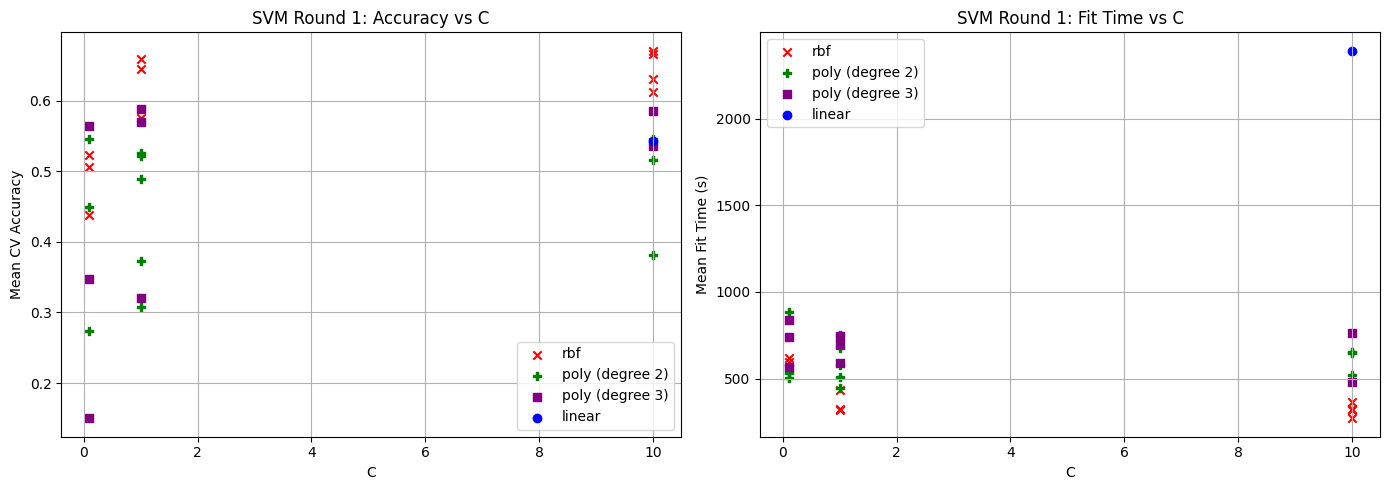

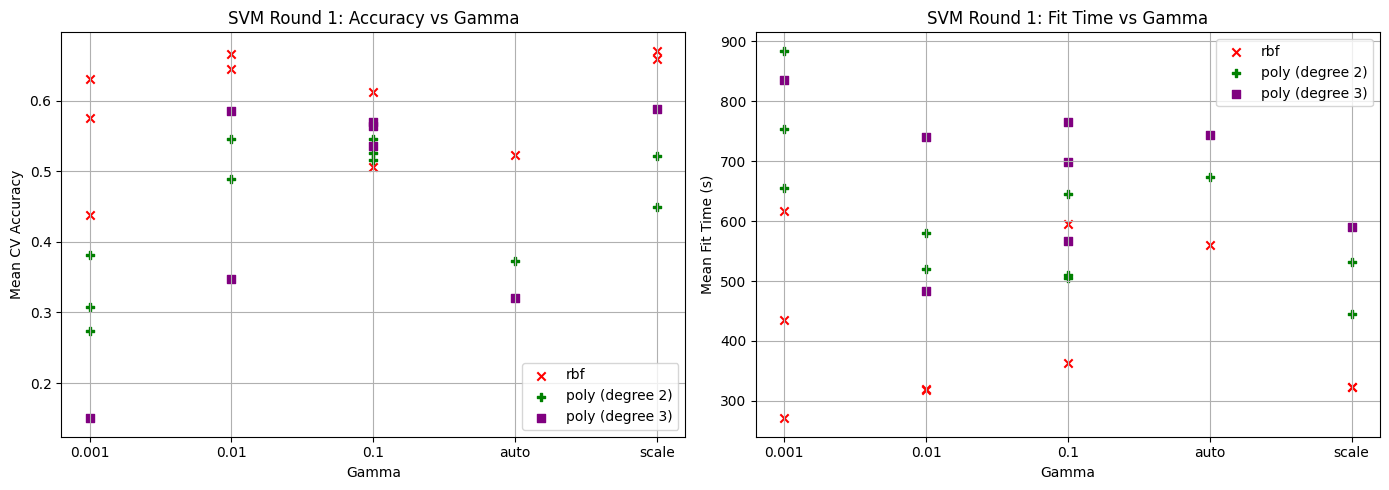

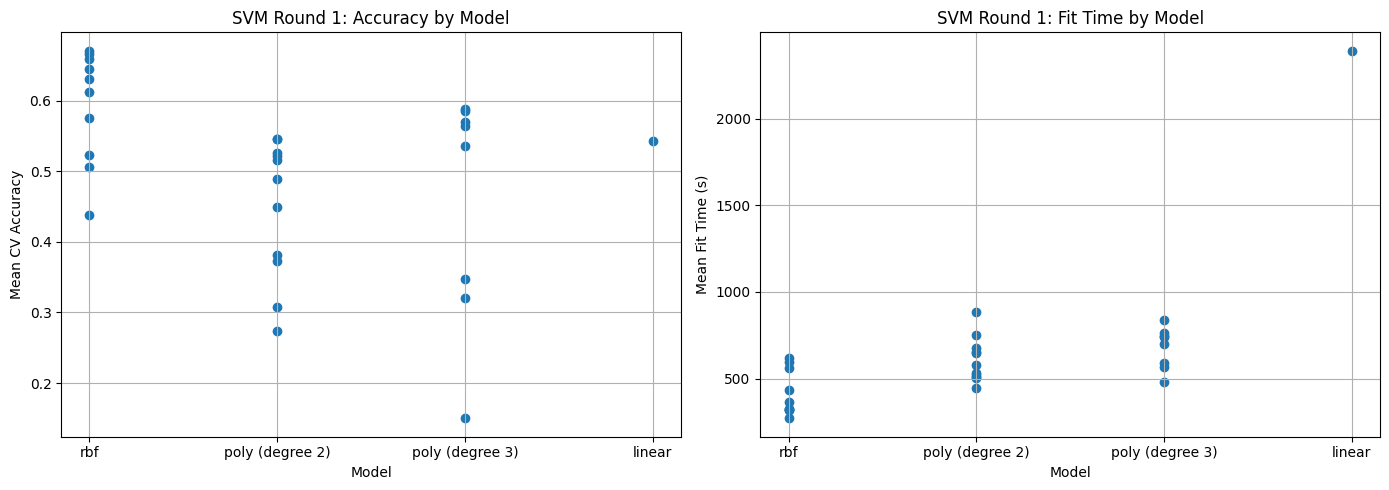

In [ ]:
# Load the first round result for visualization
df = pd.read_csv("/content/svm_1_results.csv")
df.columns = [col.lower() for col in df.columns]

# Create a "model_label" column based on kernel type and degree
df['model_label'] = df['param_kernel']
df.loc[
  (df['param_kernel'] == 'poly') & (df['param_degree'] == 2),
  'model_label'
] = 'poly (degree 2)'
df.loc[
  (df['param_kernel'] == 'poly') & (df['param_degree'] == 3),
  'model_label'
] = 'poly (degree 3)'

# Define plotting styles for each model type
model_styles = {
  'rbf': {'color': 'red', 'marker': 'x'},
  'poly (degree 2)': {'color': 'green', 'marker': 'P'},
  'poly (degree 3)': {'color': 'purple', 'marker': 's'},
  'linear': {'color': 'blue', 'marker': 'o'}
}

# Plot figure for parameter C
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for model, style in model_styles.items():
  subset = df[df['model_label'] == model]
  ax1.scatter(
    subset['param_c'],
    subset['mean_test_score'],
    c=style['color'],
    label=model,
    marker=style['marker']
  )
  ax2.scatter(
    subset['param_c'],
    subset['mean_fit_time'],
    c=style['color'],
    label=model,
    marker=style['marker']
  )
ax1.set_title('SVM Round 1: Accuracy vs C')
ax1.set_xlabel('C')
ax1.set_ylabel('Mean CV Accuracy')
ax1.grid(True)
ax1.legend()
ax2.set_title('SVM Round 1: Fit Time vs C')
ax2.set_xlabel('C')
ax2.set_ylabel('Mean Fit Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Order the gamma
df_gamma = df[df['param_gamma'].notna()].copy()
df_gamma['param_gamma_str'] = df_gamma['param_gamma'].astype(str)
gamma_order = ['0.001', '0.01', '0.1', 'auto', 'scale']
gamma_order_dict = {k: i for i, k in enumerate(gamma_order)}
df_gamma = df_gamma[df_gamma['param_gamma_str'].isin(gamma_order_dict)]
df_gamma['gamma_order'] = df_gamma['param_gamma_str'].map(gamma_order_dict)

# Plot figure for parameter gamma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for model, style in model_styles.items():
  if model != 'linear':
    subset = df_gamma[df_gamma['model_label'] == model]
    ax1.scatter(
      subset['gamma_order'],
      subset['mean_test_score'],
      c=style['color'],
      label=model,
      marker=style['marker']
    )
    ax2.scatter(
      subset['gamma_order'],
      subset['mean_fit_time'],
      c=style['color'],
      label=model,
      marker=style['marker']
    )
ax1.set_title('SVM Round 1: Accuracy vs Gamma')
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Mean CV Accuracy')
ax1.set_xticks(list(gamma_order_dict.values()))
ax1.set_xticklabels(gamma_order)
ax1.grid(True)
ax1.legend()
ax2.set_title('SVM Round 1: Fit Time vs Gamma')
ax2.set_xlabel('Gamma')
ax2.set_ylabel('Mean Fit Time (s)')
ax2.set_xticks(list(gamma_order_dict.values()))
ax2.set_xticklabels(gamma_order)
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Order the models
ordered_models = ['rbf', 'poly (degree 2)', 'poly (degree 3)', 'linear']
df['model_label'] = pd.Categorical(
  df['model_label'],
  categories=ordered_models,
  ordered=True
)
df_sorted = df.sort_values(by='model_label')

# Plot figure for different model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(df_sorted['model_label'], df_sorted['mean_test_score'])
ax1.set_title("SVM Round 1: Accuracy by Model")
ax1.set_xlabel("Model")
ax1.set_ylabel("Mean CV Accuracy")
ax1.grid(True)
ax2.scatter(df_sorted['model_label'], df_sorted['mean_fit_time'])
ax2.set_title("SVM Round 1: Fit Time by Model")
ax2.set_xlabel("Model")
ax2.set_ylabel("Mean Fit Time (s)")
ax2.grid(True)
plt.tight_layout()
plt.show()

#### Second Round

In [ ]:
# Define hyperparameters grid for the second round search
param_grid_2 = [
  {'kernel': ['linear'], 'C': [2, 4, 6, 8, 10]},
  {
    'kernel': ['rbf'],
    'C': [2, 4, 6, 8, 10],
    'gamma': ['scale', 0.01, 0.1]
  },
]  # Selected based on the first round result

# Grid search
grid_search = GridSearchCV(
  estimator=SVC(),
  param_grid=param_grid_2,
  cv=ps,
  scoring='accuracy',
  verbose=2,
  n_jobs=-1
)
grid_search.fit(X_combined, y_combined)
print(f"Round 2:\n Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# Save results
df_SVM_2 = pd.DataFrame(grid_search.cv_results_)
df_SVM_2.to_csv("svm_2_results.csv", index=False)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Round 2:
 Best parameters: {'C': 4, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.6737


##### Plotting results

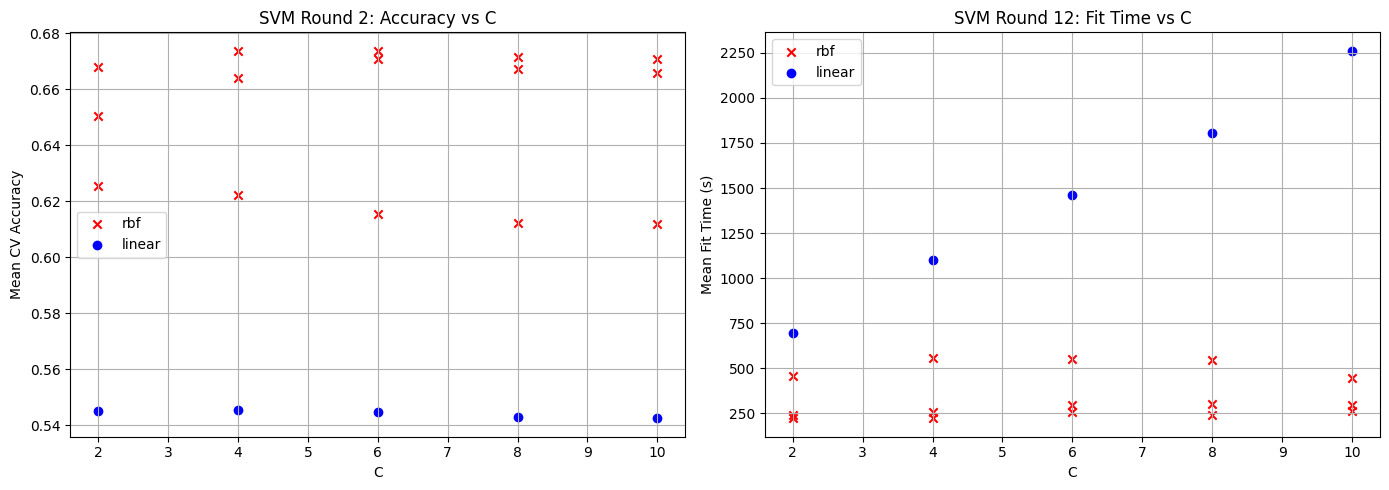

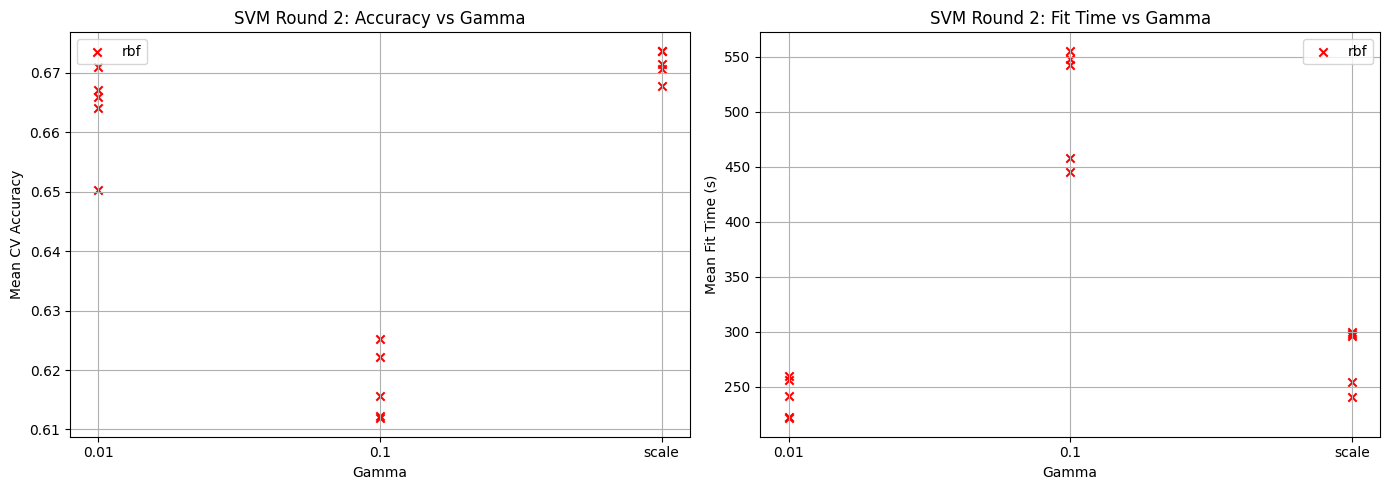

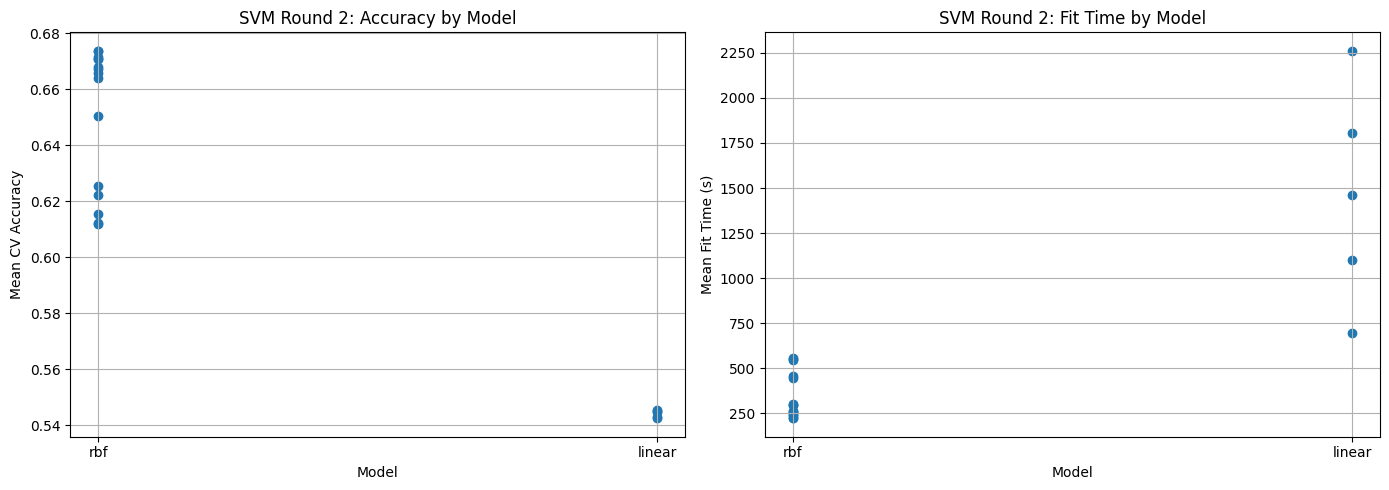

In [ ]:
# Load the second round result for visualization
df = pd.read_csv("/content/svm_2_results.csv")
df.columns = [col.lower() for col in df.columns]

df['model_label'] = df['param_kernel']

# Define plotting styles for each model type
model_styles = {
  'rbf': {'color': 'red', 'marker': 'x'},
  'linear': {'color': 'blue', 'marker': 'o'}
}

# Plot figure for parameter C
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for model, style in model_styles.items():
  subset = df[df['model_label'] == model]
  ax1.scatter(
    subset['param_c'],
    subset['mean_test_score'],
    c=style['color'], label=model,
    marker=style['marker']
  )
  ax2.scatter(
    subset['param_c'],
    subset['mean_fit_time'],
    c=style['color'],
    label=model,
    marker=style['marker']
  )
ax1.set_title('SVM Round 2: Accuracy vs C')
ax1.set_xlabel('C')
ax1.set_ylabel('Mean CV Accuracy')
ax1.grid(True)
ax1.legend()
ax2.set_title('SVM Round 12: Fit Time vs C')
ax2.set_xlabel('C')
ax2.set_ylabel('Mean Fit Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Order the gamma
df_gamma = df[df['param_gamma'].notna()].copy()
df_gamma['param_gamma_str'] = df_gamma['param_gamma'].astype(str)
gamma_order = ['0.01', '0.1', 'scale']
gamma_order_dict = {k: i for i, k in enumerate(gamma_order)}
df_gamma = df_gamma[df_gamma['param_gamma_str'].isin(gamma_order_dict)]
df_gamma['gamma_order'] = df_gamma['param_gamma_str'].map(gamma_order_dict)

# Plot figure for parameter gamma
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
for model, style in model_styles.items():
  if model != 'linear':
    subset = df_gamma[df_gamma['model_label'] == model]
    ax1.scatter(
      subset['gamma_order'],
      subset['mean_test_score'],
      c=style['color'],
      label=model,
      marker=style['marker']
    )
    ax2.scatter(
      subset['gamma_order'],
      subset['mean_fit_time'],
      c=style['color'],
      label=model,
      marker=style['marker']
    )
ax1.set_title('SVM Round 2: Accuracy vs Gamma')
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Mean CV Accuracy')
ax1.set_xticks(list(gamma_order_dict.values()))
ax1.set_xticklabels(gamma_order)
ax1.grid(True)
ax1.legend()
ax2.set_title('SVM Round 2: Fit Time vs Gamma')
ax2.set_xlabel('Gamma')
ax2.set_ylabel('Mean Fit Time (s)')
ax2.set_xticks(list(gamma_order_dict.values()))
ax2.set_xticklabels(gamma_order)
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Order the models
ordered_models = ['rbf', 'linear']
df['model_label'] = pd.Categorical(
  df['model_label'],
  categories=ordered_models,
  ordered=True
)
df_sorted = df.sort_values(by='model_label')

# Plot figure for different model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(df_sorted['model_label'], df_sorted['mean_test_score'])
ax1.set_title("SVM Round 2: Accuracy by Model")
ax1.set_xlabel("Model")
ax1.set_ylabel("Mean CV Accuracy")
ax1.grid(True)
ax2.scatter(df_sorted['model_label'], df_sorted['mean_fit_time'])
ax2.set_title("SVM Round 2: Fit Time by Model")
ax2.set_xlabel("Model")
ax2.set_ylabel("Mean Fit Time (s)")
ax2.grid(True)
plt.tight_layout()
plt.show()

### Fully connected neural network

#### First round

In [ ]:
# Define hyperparameters grid for the first round search
param_grid_mlp_r1 = {
  "activation": ["relu", "tanh"],
  "dropout_rate": [0.0, 0.2, 0.5],
  "learning_rate": [0.1, 0.01, 0.001],
  "units": [128, 256],
  "weight_decay": [1e-4, 1e-3],
  "momentum": [0.0, 0.5, 0.9]
}

# Random search
build_MLP_r1 = partial(build_MLP, param_choices=param_grid_mlp_r1)
tuner_MLP_1 = TimedRandomSearch(
  hypermodel=build_MLP_r1,
  objective="val_accuracy",
  max_trials=30,
  executions_per_trial=1,
  overwrite=True,
  directory="keras_tuner_results",
  project_name="MLP_1",
  seed=0
)
tuner_MLP_1.search(
  X_train, y_train,
  epochs=15,
  validation_data=(X_valid, y_valid),
  callbacks=[early_stop]
)

Trial 30 Complete [00h 02m 18s]
val_accuracy: 0.42500001192092896

Best val_accuracy So Far: 0.5353124737739563
Total elapsed time: 00h 35m 44s


In [ ]:
# Print summary
tuner_MLP_1.results_summary()

# Save results
trial_data_MLP_1 = []
for trial_id, trial in tuner_MLP_1.oracle.trials.items():
  row = trial.hyperparameters.values.copy()
  row["val_accuracy"] = trial.score
  row["trial_id"] = trial_id
  meta = getattr(trial, "metadata", {})
  row["training_time"] = meta.get("training_time", "")
  row["was_pruned"] = meta.get("was_pruned", "")
  row["early_stopped"] = meta.get("early_stopped", "")
  trial_data_MLP_1.append(row)
df_MLP_1 = pd.DataFrame(trial_data_MLP_1)
df_MLP_1.to_csv("mlp_1_results.csv", index=False)

Results summary
Results in keras_tuner_results/MLP_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.001
weight_decay: 0.001
momentum: 0.9
Score: 0.5353124737739563

Trial 24 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.0
Score: 0.534375011920929

Trial 00 summary
Hyperparameters:
units: 128
activation: relu
dropout_rate: 0.0
learning_rate: 0.001
weight_decay: 0.0001
momentum: 0.9
Score: 0.5259374976158142

Trial 26 summary
Hyperparameters:
units: 256
activation: tanh
dropout_rate: 0.2
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5084375143051147

Trial 21 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.2
learning_rate: 0.001
weight_decay: 0.001
momentum: 0.9
Score: 0.5018749833106995

Trial 08 summary
Hyperparameters:
units: 128
activation: tanh
dropo

##### Plotting results

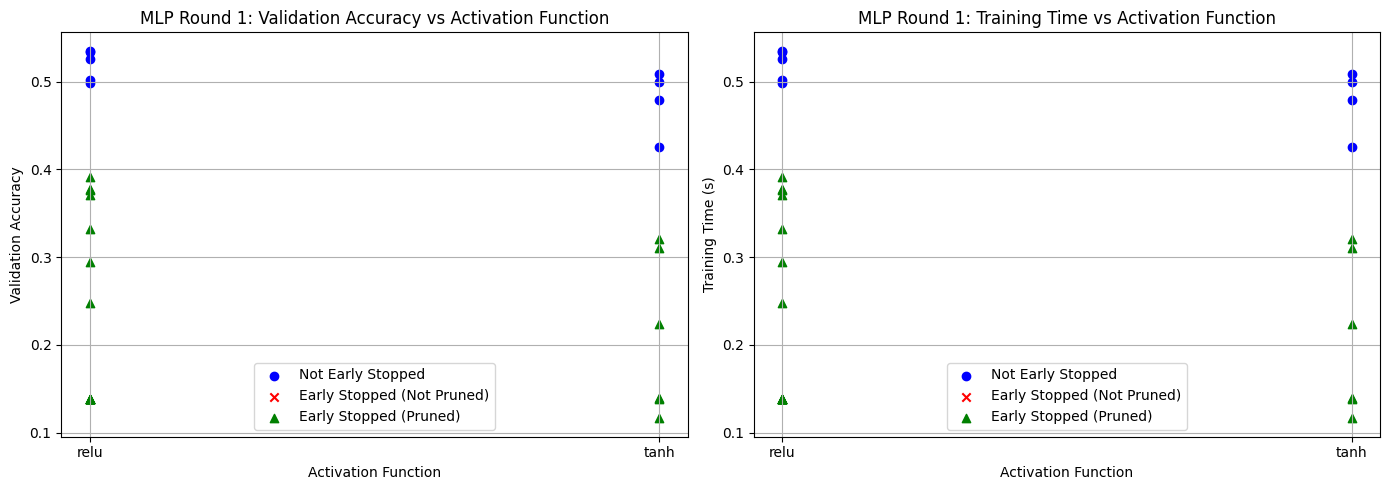

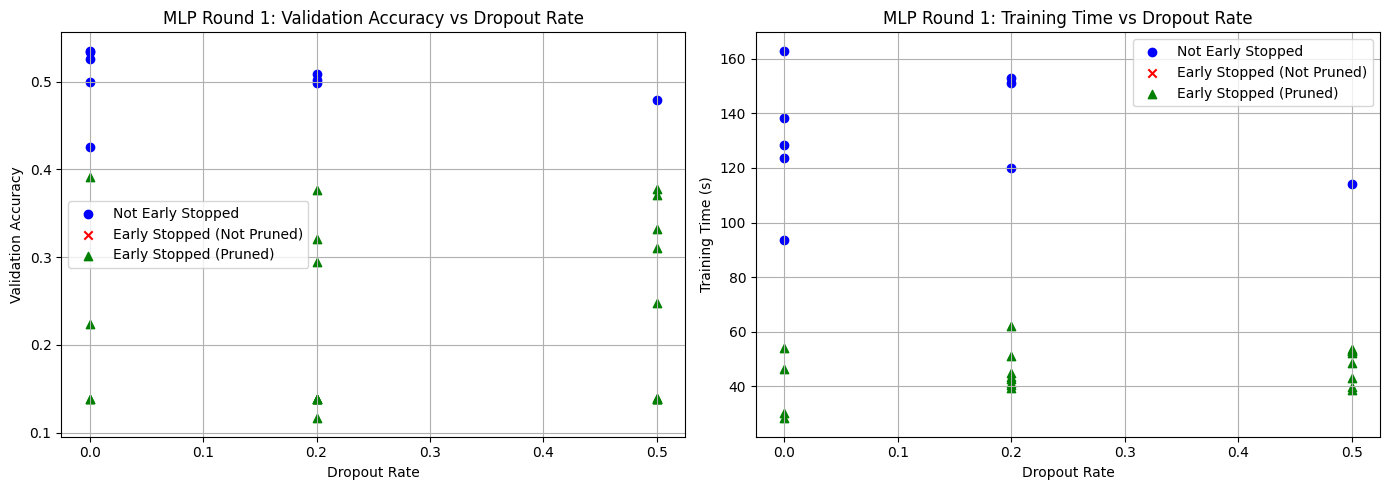

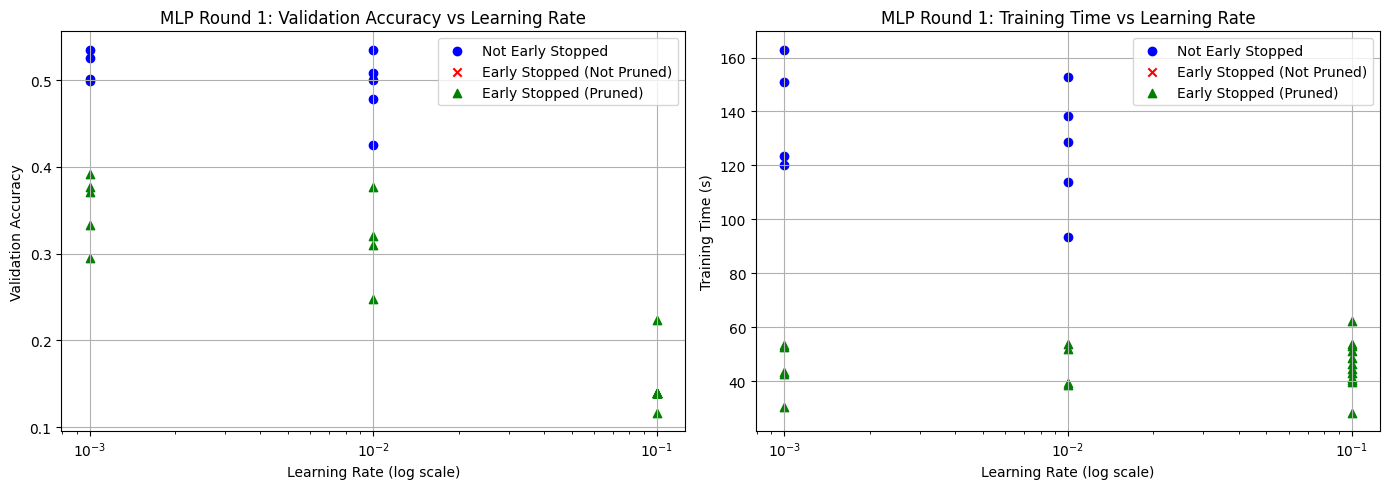

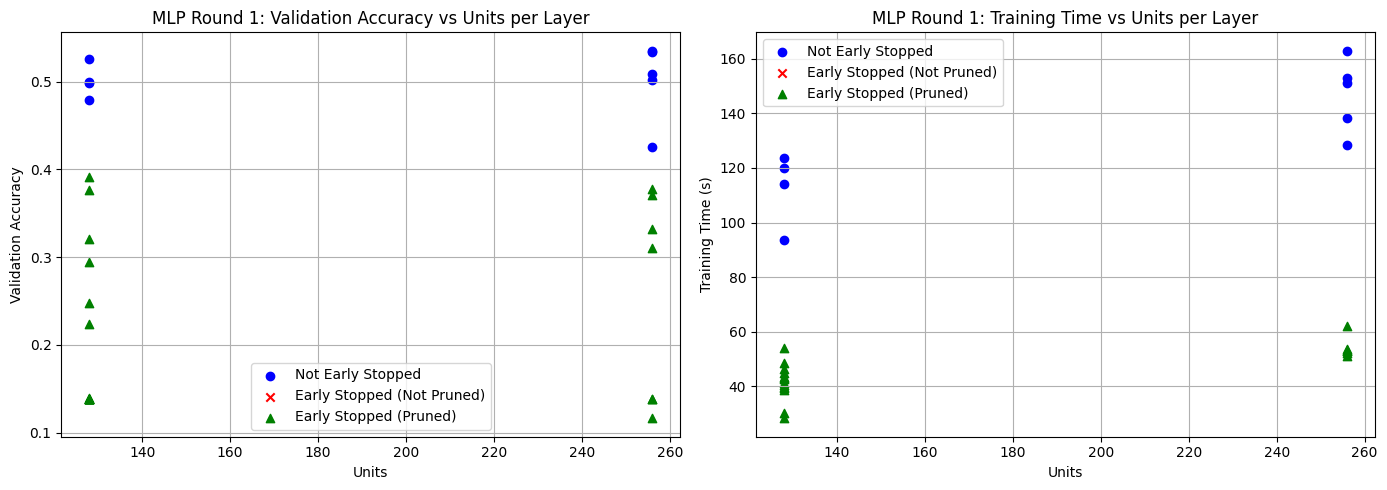

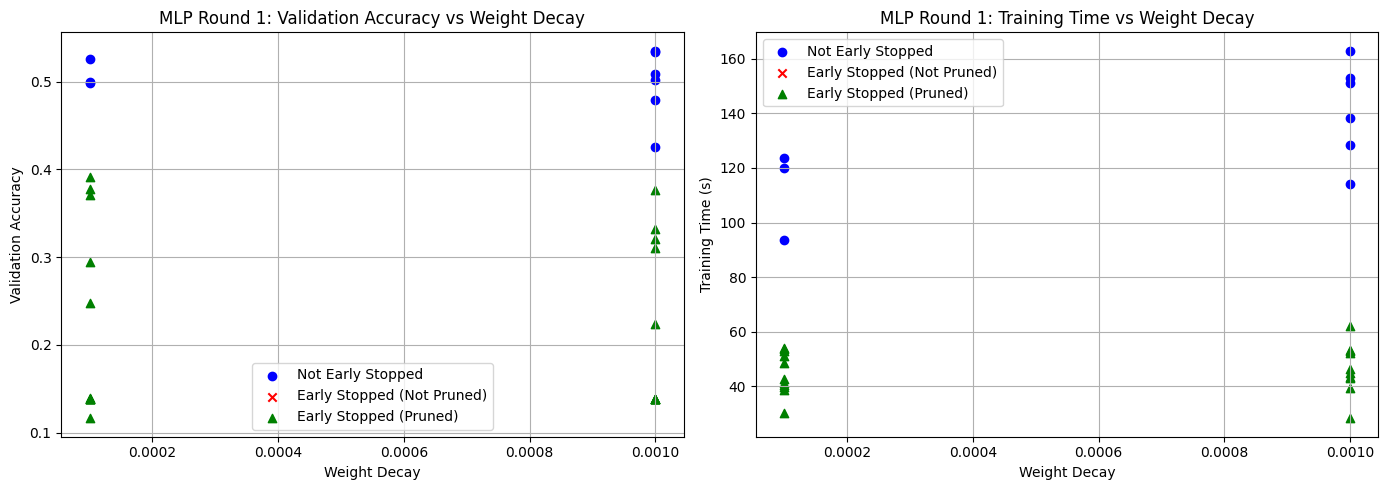

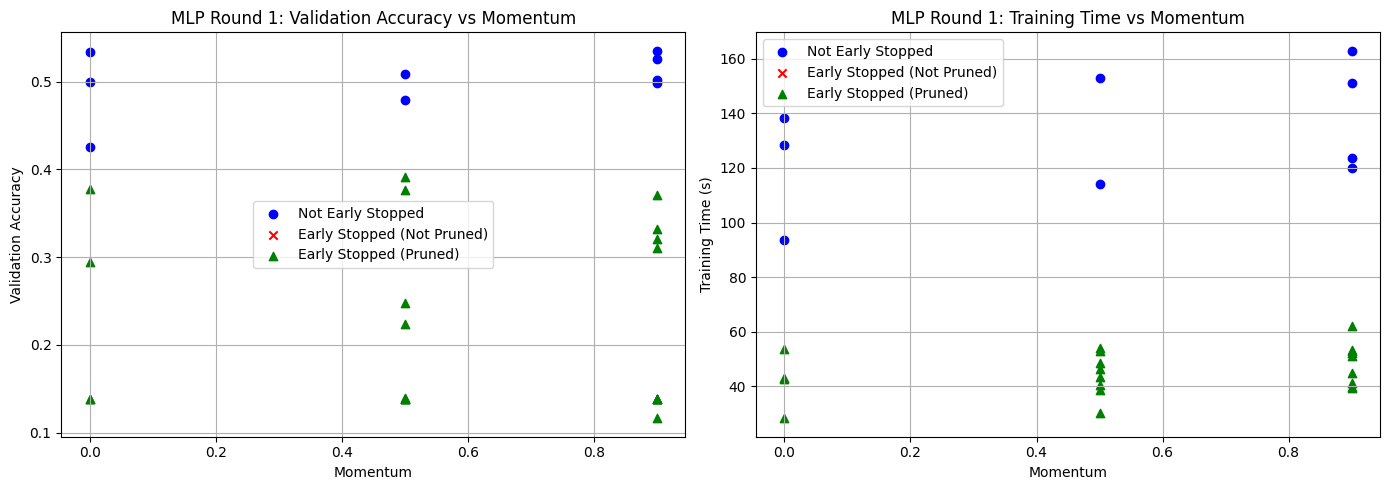

In [ ]:
# Load the first round result for visualization
mlp_r1_result = pd.read_csv("/content/mlp_1_results.csv")
mlp_1_pruned = mlp_r1_result[
  (mlp_r1_result['early_stopped'] == True) &
  (mlp_r1_result['was_pruned'] == True)
]
mlp_1_es_not_pruned = mlp_r1_result[
  (mlp_r1_result['early_stopped'] == True) &
  (mlp_r1_result['was_pruned'] == False)
]
mlp_1_not_es = mlp_r1_result[mlp_r1_result['early_stopped'] == False]


# Activation Function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['activation'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['activation'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['activation'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 1: Validation Accuracy vs Activation Function')
ax1.set_xlabel('Activation Function')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['activation'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['activation'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['activation'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 1: Training Time vs Activation Function')
ax2.set_xlabel('Activation Function')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Dropout Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['dropout_rate'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['dropout_rate'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['dropout_rate'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 1: Validation Accuracy vs Dropout Rate')
ax1.set_xlabel('Dropout Rate')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['dropout_rate'],
  mlp_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['dropout_rate'],
  mlp_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['dropout_rate'],
  mlp_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 1: Training Time vs Dropout Rate')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Learning Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['learning_rate'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['learning_rate'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['learning_rate'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_xscale('log')
ax1.set_title('MLP Round 1: Validation Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate (log scale)')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['learning_rate'],
  mlp_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['learning_rate'],
  mlp_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['learning_rate'],
  mlp_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_xscale('log')
ax2.set_title('MLP Round 1: Training Time vs Learning Rate')
ax2.set_xlabel('Learning Rate (log scale)')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Units per Layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['units'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['units'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['units'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 1: Validation Accuracy vs Units per Layer')
ax1.set_xlabel('Units')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['units'],
  mlp_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['units'],
  mlp_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['units'],
  mlp_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 1: Training Time vs Units per Layer')
ax2.set_xlabel('Units')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Weight Decay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['weight_decay'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['weight_decay'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['weight_decay'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 1: Validation Accuracy vs Weight Decay')
ax1.set_xlabel('Weight Decay')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['weight_decay'],
  mlp_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['weight_decay'],
  mlp_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['weight_decay'],
  mlp_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 1: Training Time vs Weight Decay')
ax2.set_xlabel('Weight Decay')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Momentum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_1_not_es['momentum'],
  mlp_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_1_es_not_pruned['momentum'],
  mlp_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_1_pruned['momentum'],
  mlp_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 1: Validation Accuracy vs Momentum')
ax1.set_xlabel('Momentum')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_1_not_es['momentum'],
  mlp_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_1_es_not_pruned['momentum'],
  mlp_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_1_pruned['momentum'],
  mlp_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 1: Training Time vs Momentum')
ax2.set_xlabel('Momentum')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

#### Second round

In [ ]:
# Define hyperparameters grid for the second round search
param_grid_mlp_r2 = {
  "activation": ["relu", "tanh"],
  "dropout_rate": [0.0, 0.1, 0.2],
  "learning_rate": [0.01, 0.005, 0.001],
  "units": [256],  # Fixed
  "weight_decay": [1e-3],  # Fixed
  "momentum": [0.0, 0.5, 0.9]
}  # Selected based on the first round result

# Bayesian search
build_MLP_r2 = partial(build_MLP, param_choices=param_grid_mlp_r2)
tuner_MLP_2 = TimedBayesianTuner(
  hypermodel=build_MLP_r2,
  objective="val_accuracy",
  max_trials=30,
  executions_per_trial=1,
  overwrite=True,
  directory="keras_tuner_results",
  project_name="MLP_2",
  seed=0
)
tuner_MLP_2.search(
  X_train, y_train,
  epochs=15,
  validation_data=(X_valid, y_valid),
  callbacks=[early_stop]
)

Trial 30 Complete [00h 02m 31s]
val_accuracy: 0.5512499809265137

Best val_accuracy So Far: 0.5512499809265137
Total elapsed time: 01h 07m 29s


In [ ]:
# Print summary
tuner_MLP_2.results_summary()

# Save results
trial_data_MLP_2 = []
for trial_id, trial in tuner_MLP_2.oracle.trials.items():
  row = trial.hyperparameters.values.copy()
  row["val_accuracy"] = trial.score
  row["trial_id"] = trial_id
  meta = getattr(trial, "metadata", {})
  row["training_time"] = meta.get("training_time", "")
  row["was_pruned"] = meta.get("was_pruned", "")
  row["early_stopped"] = meta.get("early_stopped", "")
  trial_data_MLP_2.append(row)
df_MLP_2 = pd.DataFrame(trial_data_MLP_2)
df_MLP_2.to_csv("mlp_2_results.csv", index=False)

Results summary
Results in keras_tuner_results/MLP_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 29 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5512499809265137

Trial 25 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5471875071525574

Trial 26 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5471875071525574

Trial 23 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5459374785423279

Trial 28 summary
Hyperparameters:
units: 256
activation: relu
dropout_rate: 0.0
learning_rate: 0.01
weight_decay: 0.001
momentum: 0.5
Score: 0.5450000166893005

Trial 24 summary
Hyperparameters:
units: 256
activation: relu
dropout_

##### Plotting results

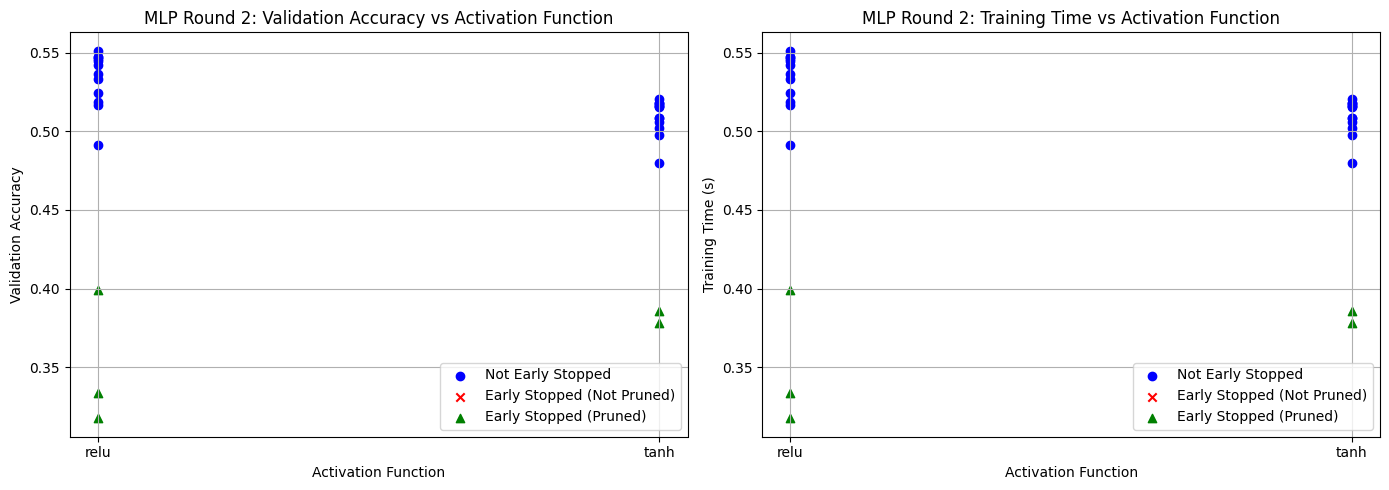

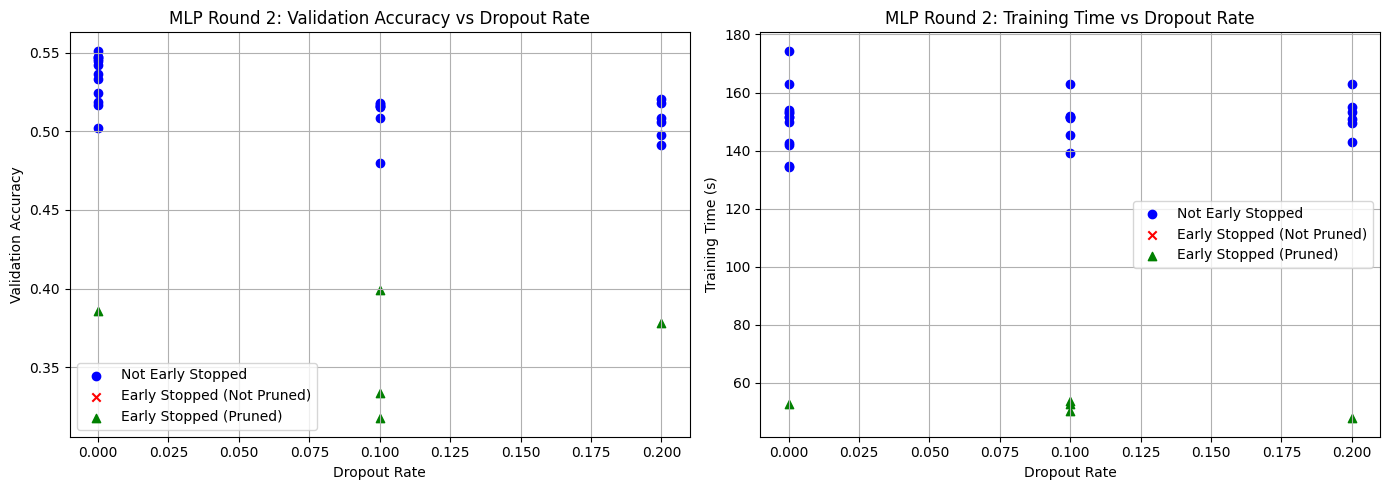

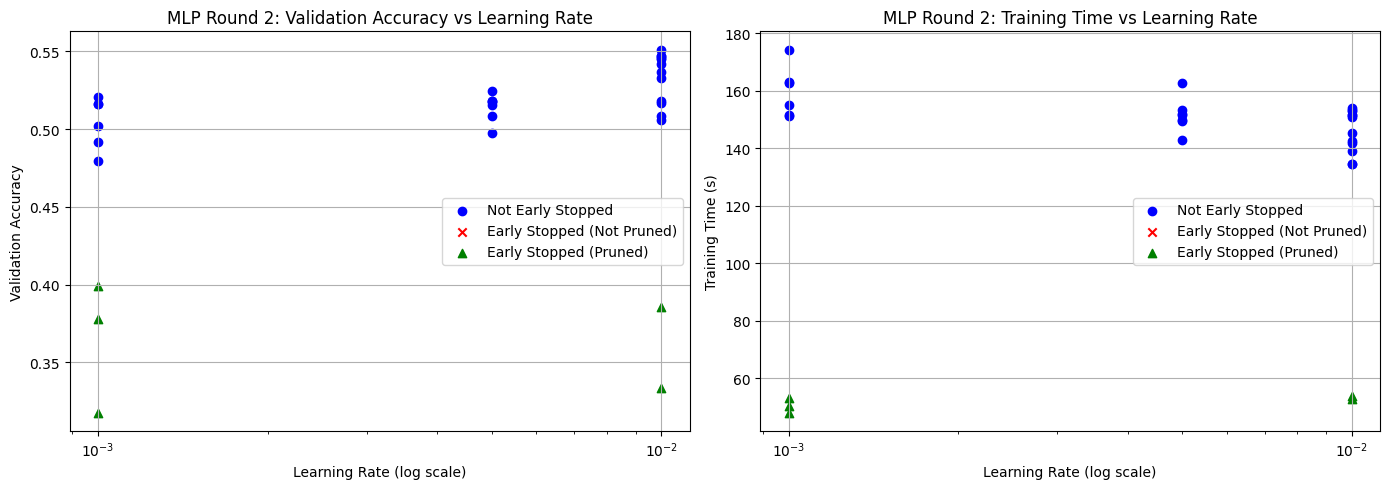

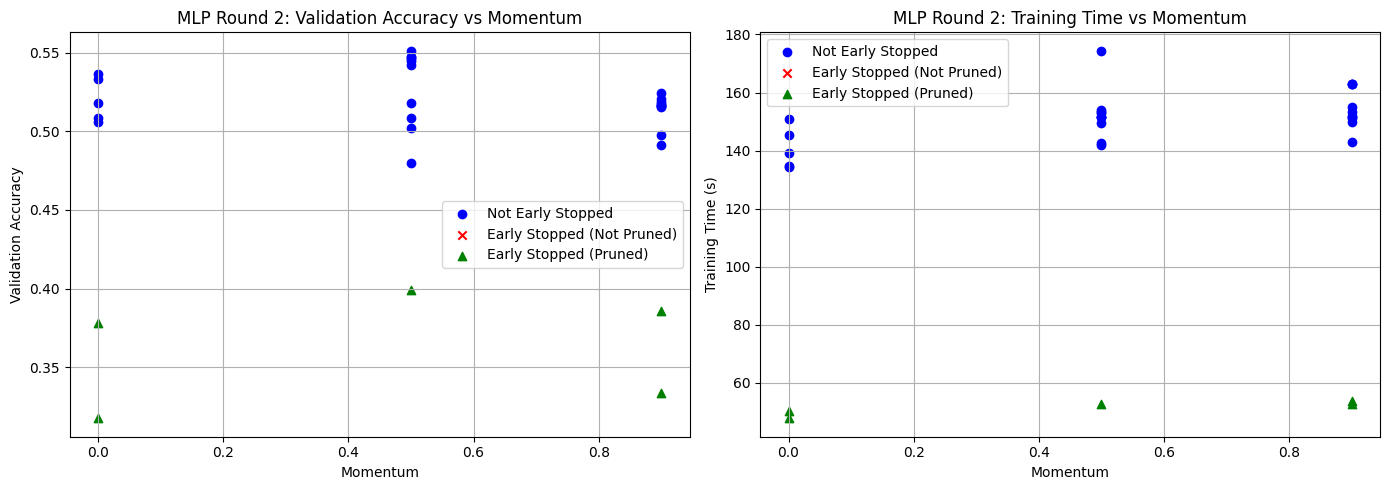

In [ ]:
# Load the second round result for visualization
mlp_r2_result = pd.read_csv("/content/mlp_2_results.csv")
mlp_2_pruned = mlp_r2_result[
  (mlp_r2_result['early_stopped'] == True) &
  (mlp_r2_result['was_pruned'] == True)
]
mlp_2_es_not_pruned = mlp_r2_result[
  (mlp_r2_result['early_stopped'] == True) &
  (mlp_r2_result['was_pruned'] == False)
]
mlp_2_not_es = mlp_r2_result[mlp_r2_result['early_stopped'] == False]


# Activation Function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_2_not_es['activation'],
  mlp_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_2_es_not_pruned['activation'],
  mlp_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_2_pruned['activation'],
  mlp_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 2: Validation Accuracy vs Activation Function')
ax1.set_xlabel('Activation Function')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_2_not_es['activation'],
  mlp_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_2_es_not_pruned['activation'],
  mlp_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_2_pruned['activation'],
  mlp_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 2: Training Time vs Activation Function')
ax2.set_xlabel('Activation Function')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Dropout Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_2_not_es['dropout_rate'],
  mlp_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_2_es_not_pruned['dropout_rate'],
  mlp_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_2_pruned['dropout_rate'],
  mlp_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 2: Validation Accuracy vs Dropout Rate')
ax1.set_xlabel('Dropout Rate')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_2_not_es['dropout_rate'],
  mlp_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_2_es_not_pruned['dropout_rate'],
  mlp_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_2_pruned['dropout_rate'],
  mlp_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 2: Training Time vs Dropout Rate')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Learning Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_2_not_es['learning_rate'],
  mlp_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_2_es_not_pruned['learning_rate'],
  mlp_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_2_pruned['learning_rate'],
  mlp_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_xscale('log')
ax1.set_title('MLP Round 2: Validation Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate (log scale)')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_2_not_es['learning_rate'],
  mlp_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_2_es_not_pruned['learning_rate'],
  mlp_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_2_pruned['learning_rate'],
  mlp_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_xscale('log')
ax2.set_title('MLP Round 2: Training Time vs Learning Rate')
ax2.set_xlabel('Learning Rate (log scale)')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()


# Momentum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  mlp_2_not_es['momentum'],
  mlp_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  mlp_2_es_not_pruned['momentum'],
  mlp_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  mlp_2_pruned['momentum'],
  mlp_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('MLP Round 2: Validation Accuracy vs Momentum')
ax1.set_xlabel('Momentum')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  mlp_2_not_es['momentum'],
  mlp_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  mlp_2_es_not_pruned['momentum'],
  mlp_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  mlp_2_pruned['momentum'],
  mlp_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('MLP Round 2: Training Time vs Momentum')
ax2.set_xlabel('Momentum')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

### Convolutional neural network

#### First round

In [ ]:
# Define hyperparameters grid for the first round search
param_grid_round1 = {
  "filters": [32, 64, 128],
  "kernel_size": ["3x3", "5x5", "7x7"],
  "stride_size": ["1x1", "2x2"],
  "pool_size": ["2x2", "3x3"],
  "dropout_rate": [0.0, 0.2, 0.5],
  "learning_rate": [0.01, 0.001, 0.0001]
}

# Random search
build_CNN_r1 = partial(build_CNN, param_choices=param_grid_round1)
tuner_CNN_1 = TimedRandomSearch(
  hypermodel=build_CNN_r1,
  objective="val_accuracy",
  max_trials=30,
  executions_per_trial=1,
  overwrite=True,
  directory="keras_tuner_results",
  project_name="CNN_1",
  seed=0,
  max_consecutive_failed_trials=20  # for unsave cofigs
)
tuner_CNN_1.search(
  X_train, y_train,
  epochs=15,
  validation_data=(X_valid, y_valid),
  callbacks=[early_stop]
)


Trial 30 Complete [00h 34m 37s]
val_accuracy: 0.7049999833106995

Best val_accuracy So Far: 0.7774999737739563
Total elapsed time: 08h 55m 45s


In [ ]:
# Print summary
tuner_CNN_1.results_summary()

# Save results
trial_data_CNN_1 = []
for trial_id, trial in tuner_CNN_1.oracle.trials.items():
  row = trial.hyperparameters.values.copy()
  row["val_accuracy"] = trial.score
  row["trial_id"] = trial_id
  meta = getattr(trial, "metadata", {})
  row["training_time"] = meta.get("training_time", "")
  row["was_pruned"] = meta.get("was_pruned", "")
  row["early_stopped"] = meta.get("early_stopped", "")
  trial_data_CNN_1.append(row)
df_CNN_1 = pd.DataFrame(trial_data_CNN_1)
df_CNN_1.to_csv("cnn_1_results.csv", index=False)

Results summary
Results in keras_tuner_results/CNN_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 19 summary
Hyperparameters:
filters: 128
dropout_rate: 0.0
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 3x3
Score: 0.7774999737739563

Trial 00 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 5x5
stride_size: 1x1
pool_size: 3x3
Score: 0.7756249904632568

Trial 01 summary
Hyperparameters:
filters: 128
dropout_rate: 0.2
learning_rate: 0.0001
kernel_size: 5x5
stride_size: 1x1
pool_size: 2x2
Score: 0.7503125071525574

Trial 04 summary
Hyperparameters:
filters: 64
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 7x7
stride_size: 1x1
pool_size: 3x3
Score: 0.7425000071525574

Trial 16 summary
Hyperparameters:
filters: 64
dropout_rate: 0.0
learning_rate: 0.001
kernel_size: 5x5
stride_size: 2x2
pool_size: 2x2
Score: 0.7396875023841858

Trial 02 summary
Hyperparameters:
filters: 64
dropout_rate: 0.0
lea

##### Plotting results

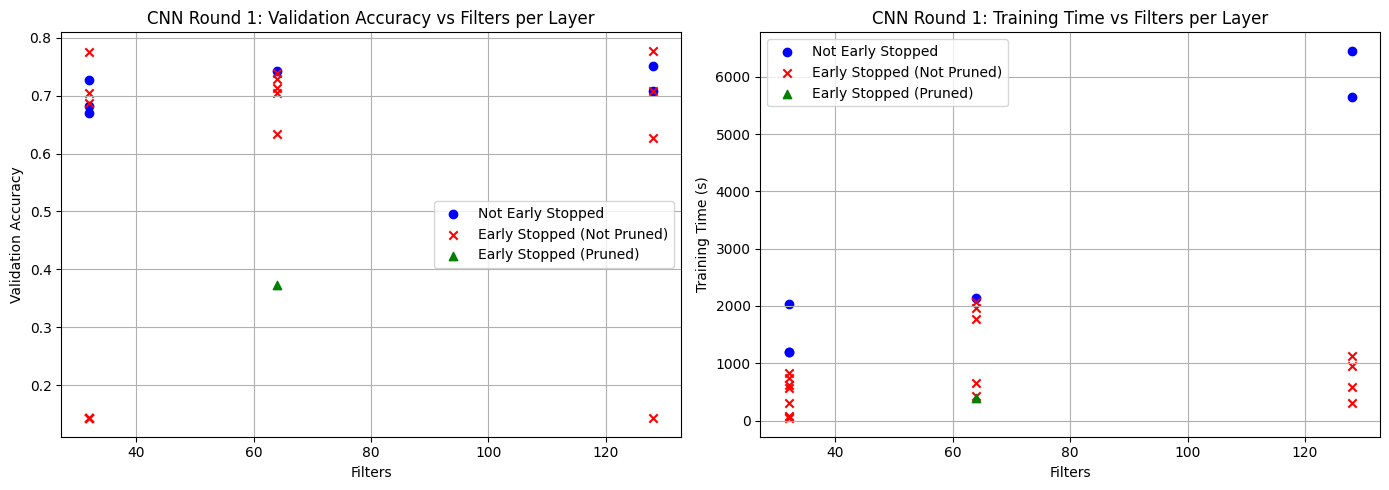

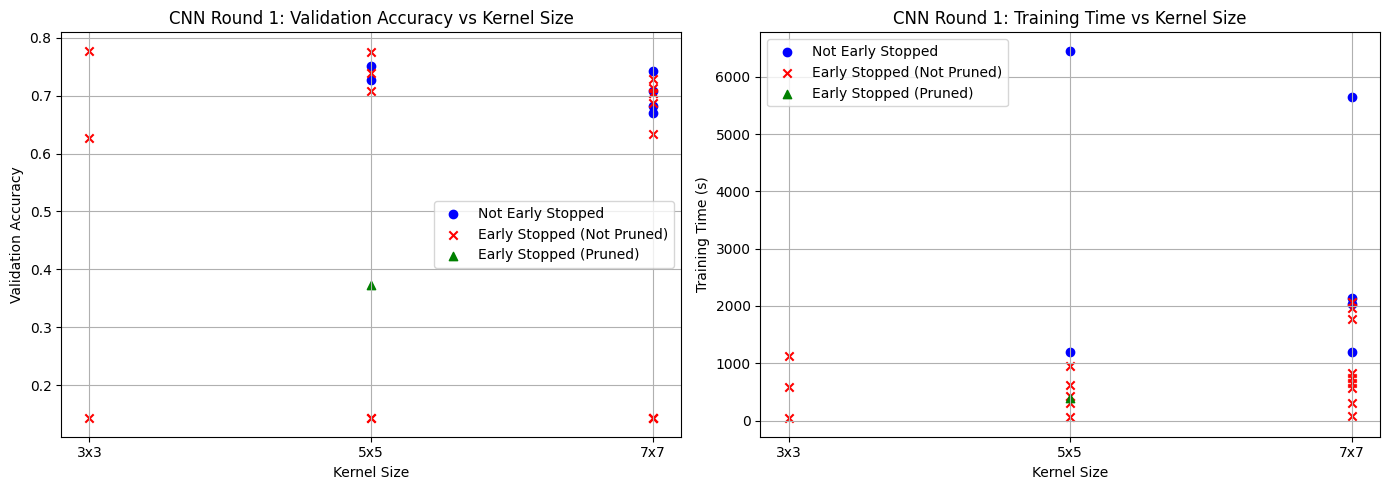

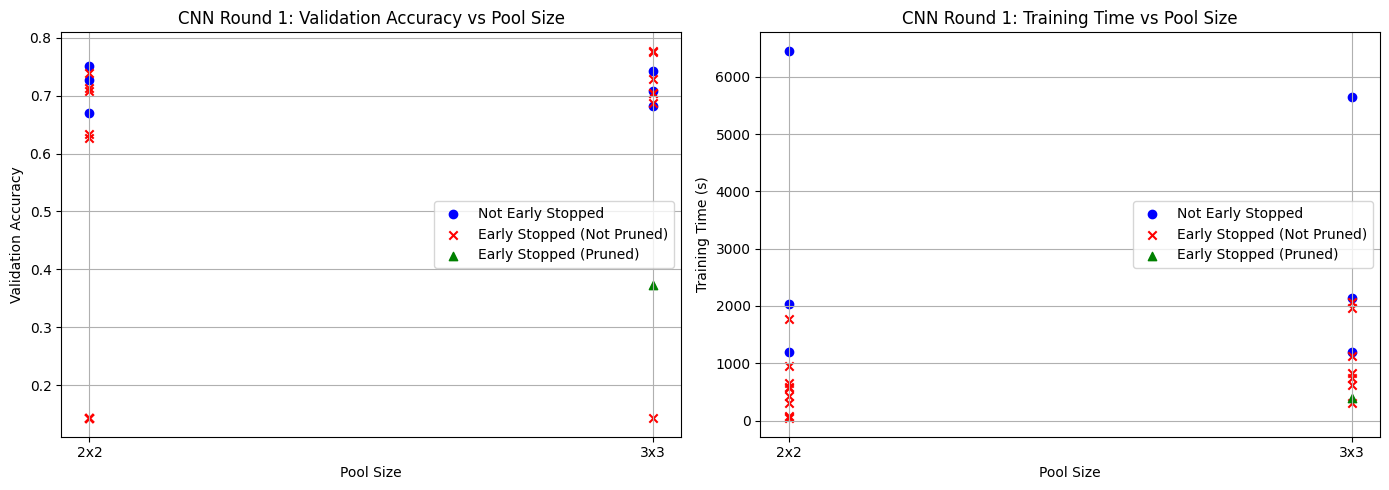

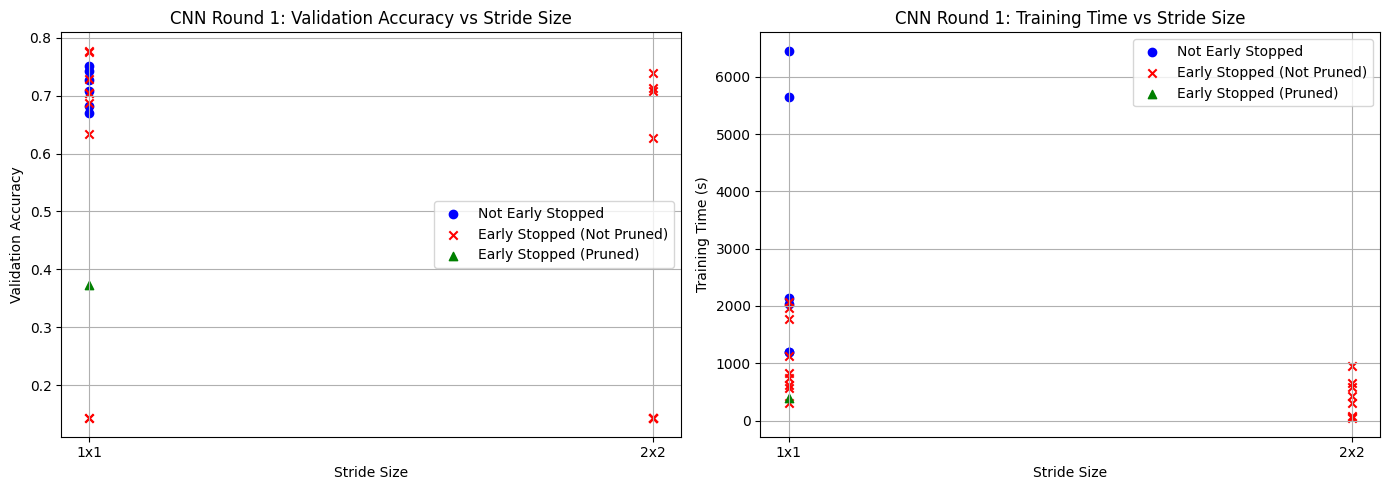

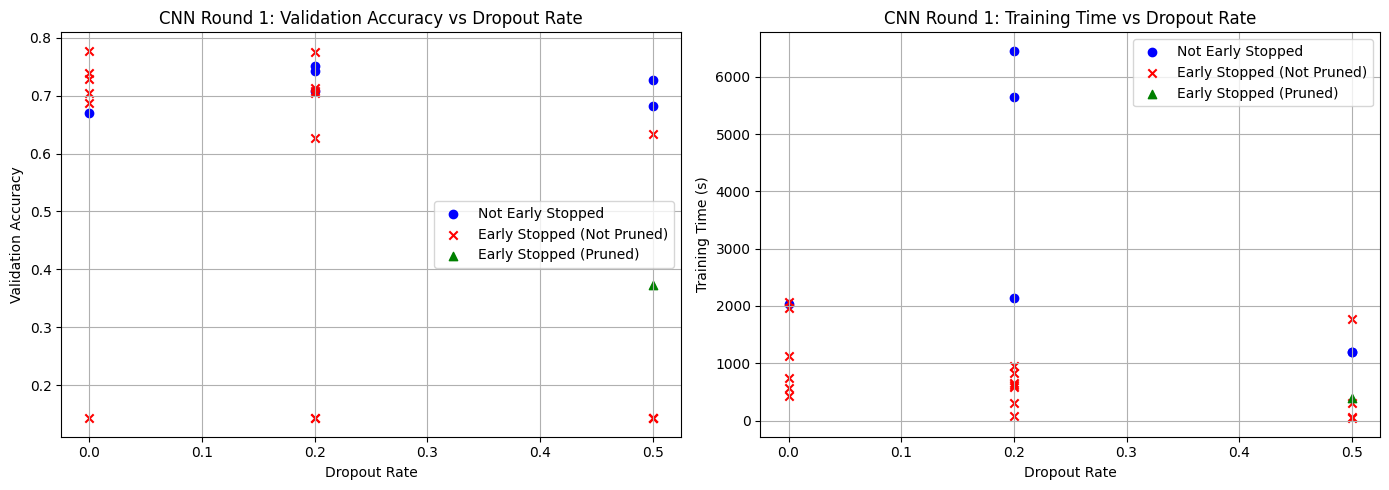

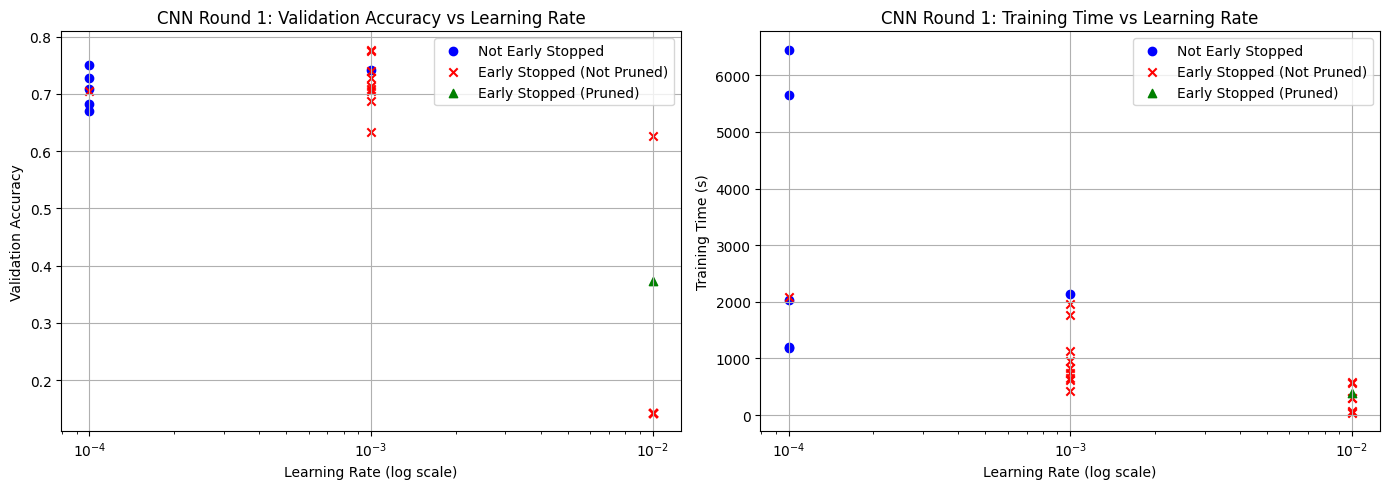

In [ ]:
# Load the first round result for visualization
cnn_r1_result = pd.read_csv("/content/cnn_1_results.csv")
cnn_1_not_es = cnn_r1_result[cnn_r1_result['early_stopped'] == False]
cnn_1_es_not_pruned = (cnn_r1_result)[
  (cnn_r1_result['early_stopped'] == True) &
  (cnn_r1_result['was_pruned'] == False)
]
cnn_1_pruned = cnn_r1_result[
  (cnn_r1_result['early_stopped'] == True) &
  (cnn_r1_result['was_pruned'] == True)
]

# Filters per Layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_1_not_es['filters'],
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_1_es_not_pruned['filters'],
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_1_pruned['filters'],
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 1: Validation Accuracy vs Filters per Layer')
ax1.set_xlabel('Filters')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_1_not_es['filters'],
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)

ax2.scatter(
  cnn_1_es_not_pruned['filters'],
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_1_pruned['filters'],
  cnn_1_pruned['training_time'],
  c='green', label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 1: Training Time vs Filters per Layer')
ax2.set_xlabel('Filters')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Kernel Size
kernel_order = {'3x3': 1, '5x5': 2, '7x7': 3}
x1_kernel_false = cnn_1_not_es['kernel_size'].map(kernel_order)
x1_kernel_true = cnn_1_es_not_pruned['kernel_size'].map(kernel_order)
x1_kernel_pruned = cnn_1_pruned['kernel_size'].map(kernel_order)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  x1_kernel_false,
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  x1_kernel_true,
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  x1_kernel_pruned,
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 1: Validation Accuracy vs Kernel Size')
ax1.set_xlabel('Kernel Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['3x3', '5x5', '7x7'])
ax1.grid(True)
ax1.legend()
ax2.scatter(
  x1_kernel_false,
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  x1_kernel_true,
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  x1_kernel_pruned,
  cnn_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 1: Training Time vs Kernel Size')
ax2.set_xlabel('Kernel Size')
ax2.set_ylabel('Training Time (s)')
ax2.set_xticks([1, 2, 3])
ax2.set_xticklabels(['3x3', '5x5', '7x7'])
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Pool Size
pool_order = {'2x2': 1, '3x3': 2}
x1_pool_false = cnn_1_not_es['pool_size'].map(pool_order)
x1_pool_true = cnn_1_es_not_pruned['pool_size'].map(pool_order)
x1_pool_pruned = cnn_1_pruned['pool_size'].map(pool_order)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  x1_pool_false,
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  x1_pool_true,
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  x1_pool_pruned,
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 1: Validation Accuracy vs Pool Size')
ax1.set_xlabel('Pool Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['2x2', '3x3'])
ax1.grid(True)
ax1.legend()
ax2.scatter(
  x1_pool_false,
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  x1_pool_true,
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  x1_pool_pruned,
  cnn_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 1: Training Time vs Pool Size')
ax2.set_xlabel('Pool Size')
ax2.set_ylabel('Training Time (s)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['2x2', '3x3'])
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Stride Size
stride_order = {'1x1': 1, '2x2': 2}
x1_stride_false = cnn_1_not_es['stride_size'].map(stride_order)
x1_stride_true = cnn_1_es_not_pruned['stride_size'].map(stride_order)
x1_stride_pruned = cnn_1_pruned['stride_size'].map(stride_order)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  x1_stride_false,
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  x1_stride_true,
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  x1_stride_pruned,
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 1: Validation Accuracy vs Stride Size')
ax1.set_xlabel('Stride Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['1x1', '2x2'])
ax1.grid(True)
ax1.legend()
ax2.scatter(
  x1_stride_false,
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  x1_stride_true,
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  x1_stride_pruned,
  cnn_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 1: Training Time vs Stride Size')
ax2.set_xlabel('Stride Size')
ax2.set_ylabel('Training Time (s)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['1x1', '2x2'])
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Dropout Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_1_not_es['dropout_rate'],
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_1_es_not_pruned['dropout_rate'],
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_1_pruned['dropout_rate'],
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 1: Validation Accuracy vs Dropout Rate')
ax1.set_xlabel('Dropout Rate')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_1_not_es['dropout_rate'],
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  cnn_1_es_not_pruned['dropout_rate'],
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_1_pruned['dropout_rate'],
  cnn_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 1: Training Time vs Dropout Rate')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Learning Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_1_not_es['learning_rate'],
  cnn_1_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_1_es_not_pruned['learning_rate'],
  cnn_1_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_1_pruned['learning_rate'],
  cnn_1_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_xscale('log')
ax1.set_title('CNN Round 1: Validation Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate (log scale)')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_1_not_es['learning_rate'],
  cnn_1_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  cnn_1_es_not_pruned['learning_rate'],
  cnn_1_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_1_pruned['learning_rate'],
  cnn_1_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_xscale('log')
ax2.set_title('CNN Round 1: Training Time vs Learning Rate')
ax2.set_xlabel('Learning Rate (log scale)')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

#### Second round

In [ ]:
# Define hyperparameters grid for the second round search
param_grid_round2 = {
  # Due to runtime & 32 filters had 2nd best result in round 1
  "filters": [16, 32],
  "kernel_size": ["3x3", "5x5"],
  "stride_size": ["1x1"],  # Fixed
  "pool_size": ["2x2", "3x3"],
  "dropout_rate": [0.0, 0.1, 0.2],
  "learning_rate": [0.001, 0.0005, 0.0001]
}  # Selected based on the first round result

# Bayesian search
build_CNN_r2 = partial(build_CNN, param_choices=param_grid_round2)
tuner_CNN_2 = TimedBayesianTuner(
  hypermodel=build_CNN_r2,
  objective="val_accuracy",
  max_trials=30,
  executions_per_trial=1,
  overwrite=True,
  directory="keras_tuner_results",
  project_name="CNN_2",
  seed=0,
  max_consecutive_failed_trials=20  # for unsave cofigs
)
tuner_CNN_2.search(
  X_train, y_train,
  epochs=15,
  validation_data=(X_valid, y_valid),
  callbacks=[early_stop]
)


Trial 30 Complete [00h 09m 46s]
val_accuracy: 0.8100000023841858

Best val_accuracy So Far: 0.8256250023841858
Total elapsed time: 05h 08m 26s


In [ ]:
# Print summary
tuner_CNN_2.results_summary()

# Save results
trial_data_CNN_2 = []
for trial_id, trial in tuner_CNN_2.oracle.trials.items():
  row = trial.hyperparameters.values.copy()
  row["val_accuracy"] = trial.score
  row["trial_id"] = trial_id
  meta = getattr(trial, "metadata", {})
  row["training_time"] = meta.get("training_time", "")
  row["was_pruned"] = meta.get("was_pruned", "")
  row["early_stopped"] = meta.get("early_stopped", "")
  trial_data_CNN_2.append(row)
df_CNN_2 = pd.DataFrame(trial_data_CNN_2)
df_CNN_2.to_csv("cnn_2_results.csv", index=False)


Results summary
Results in keras_tuner_results/CNN_2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 22 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 2x2
Score: 0.8256250023841858

Trial 20 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 2x2
Score: 0.8218749761581421

Trial 23 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 2x2
Score: 0.8184375166893005

Trial 28 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 2x2
Score: 0.8134375214576721

Trial 12 summary
Hyperparameters:
filters: 32
dropout_rate: 0.1
learning_rate: 0.001
kernel_size: 3x3
stride_size: 1x1
pool_size: 2x2
Score: 0.8118749856948853

Trial 29 summary
Hyperparameters:
filters: 32
dropout_rate: 0.2
learni

##### Plotting results

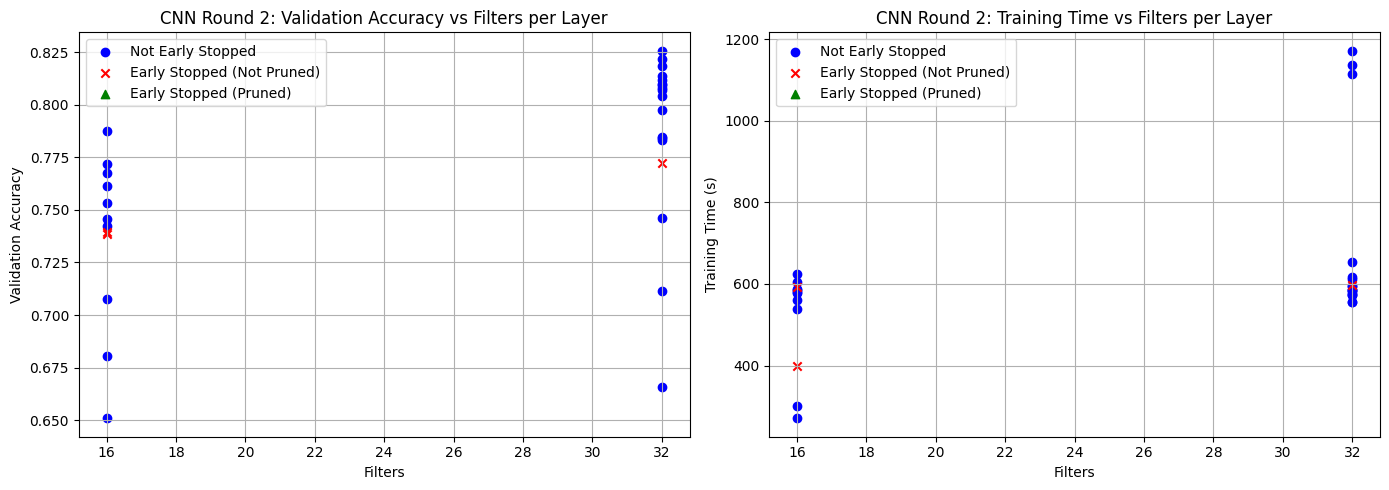

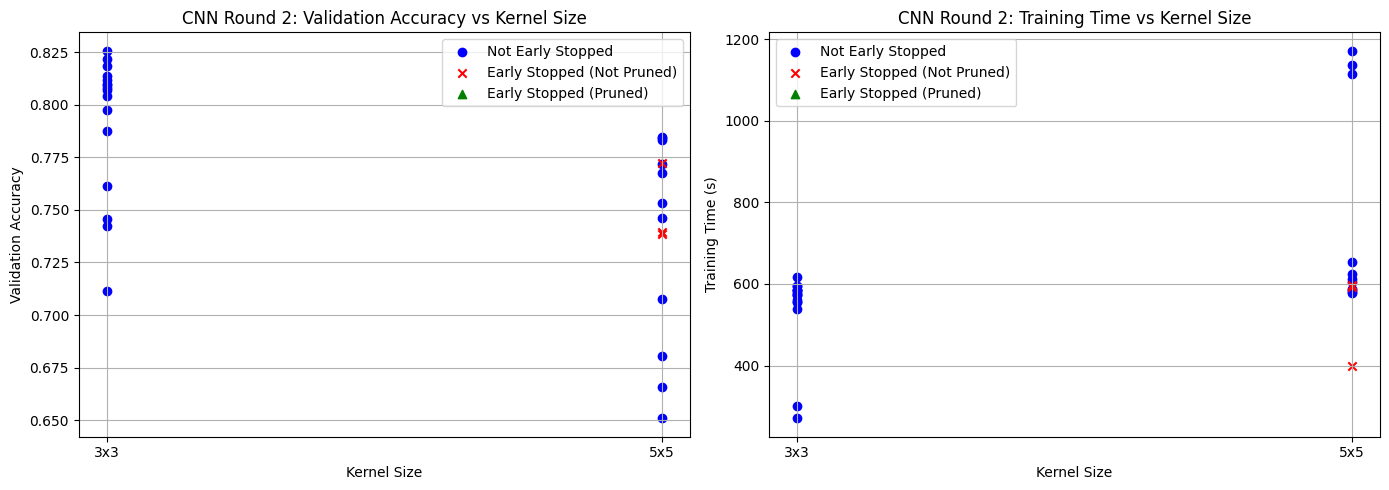

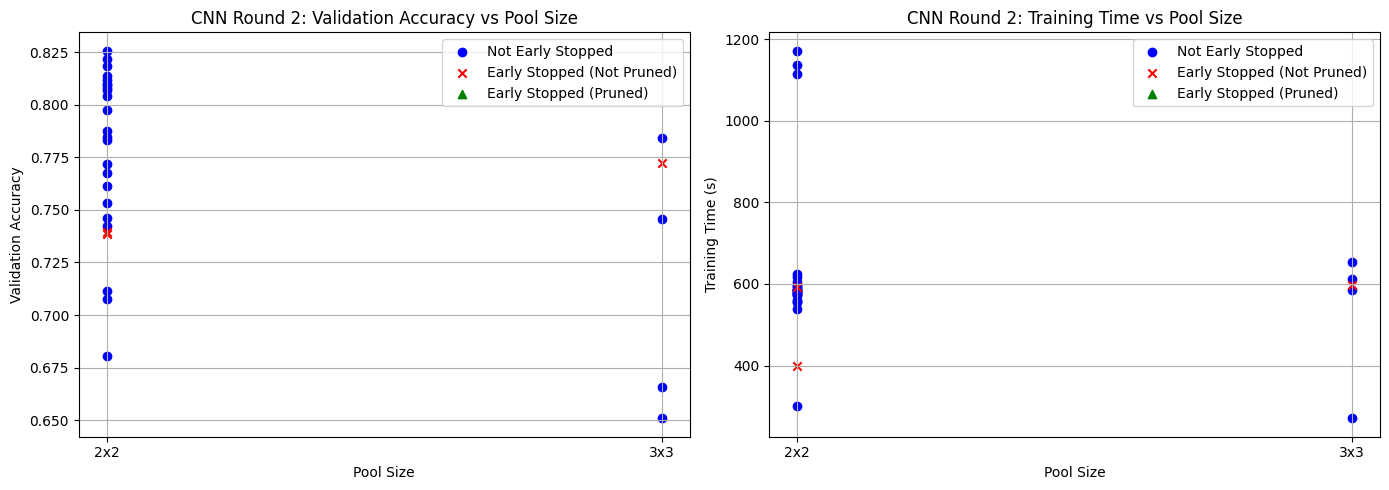

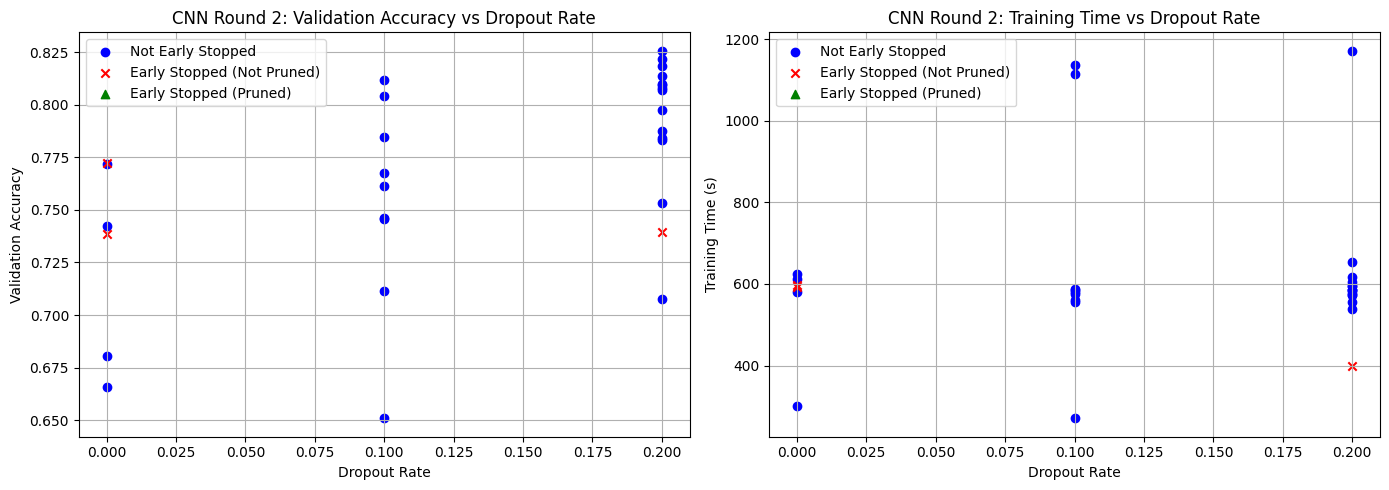

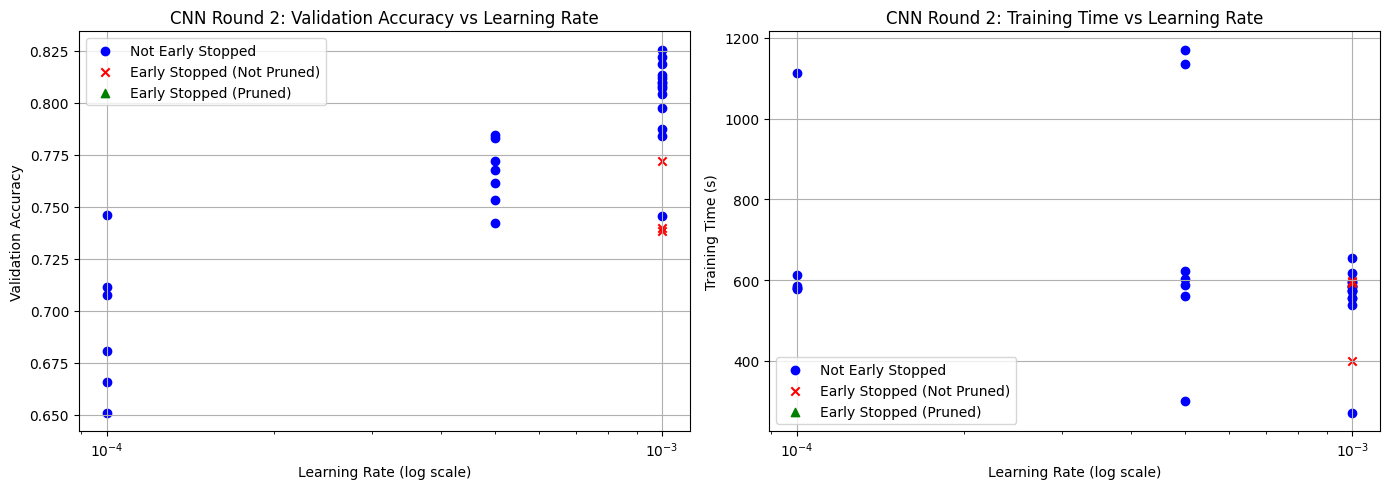

In [ ]:
# Load the second round result for visualization
cnn_r2_result = pd.read_csv("/content/cnn_2_results.csv")
cnn_2_not_es = cnn_r2_result[cnn_r2_result['early_stopped'] == False]
cnn_2_es_not_pruned = cnn_r2_result[
  (cnn_r2_result['early_stopped'] == True) &
  (cnn_r2_result['was_pruned'] == False)
]
cnn_2_pruned = cnn_r2_result[
  (cnn_r2_result['early_stopped'] == True) &
  (cnn_r2_result['was_pruned'] == True)
]

# Filters per Layer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_2_not_es['filters'],
  cnn_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_2_es_not_pruned['filters'],
  cnn_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_2_pruned['filters'],
  cnn_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 2: Validation Accuracy vs Filters per Layer')
ax1.set_xlabel('Filters')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_2_not_es['filters'],
  cnn_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  cnn_2_es_not_pruned['filters'],
  cnn_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_2_pruned['filters'],
  cnn_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 2: Training Time vs Filters per Layer')
ax2.set_xlabel('Filters')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Kernel Size
kernel_order = {'3x3': 1, '5x5': 2}
x2_kernel_false = cnn_2_not_es['kernel_size'].map(kernel_order)
x2_kernel_true = cnn_2_es_not_pruned['kernel_size'].map(kernel_order)
x2_kernel_pruned = cnn_2_pruned['kernel_size'].map(kernel_order)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  x2_kernel_false,
  cnn_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  x2_kernel_true,
  cnn_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  x2_kernel_pruned,
  cnn_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 2: Validation Accuracy vs Kernel Size')
ax1.set_xlabel('Kernel Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['3x3', '5x5'])
ax1.grid(True)
ax1.legend()
ax2.scatter(
  x2_kernel_false,
  cnn_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  x2_kernel_true,
  cnn_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  x2_kernel_pruned,
  cnn_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 2: Training Time vs Kernel Size')
ax2.set_xlabel('Kernel Size')
ax2.set_ylabel('Training Time (s)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['3x3', '5x5'])
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Pool Size
pool_order = {'2x2': 1, '3x3': 2}
x2_pool_false = cnn_2_not_es['pool_size'].map(pool_order)
x2_pool_true = cnn_2_es_not_pruned['pool_size'].map(pool_order)
x2_pool_pruned = cnn_2_pruned['pool_size'].map(pool_order)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  x2_pool_false,
  cnn_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  x2_pool_true,
  cnn_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  x2_pool_pruned,
  cnn_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 2: Validation Accuracy vs Pool Size')
ax1.set_xlabel('Pool Size')
ax1.set_ylabel('Validation Accuracy')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['2x2', '3x3'])
ax1.grid(True)
ax1.legend()
ax2.scatter(
  x2_pool_false,
  cnn_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  x2_pool_true,
  cnn_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  x2_pool_pruned,
  cnn_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 2: Training Time vs Pool Size')
ax2.set_xlabel('Pool Size')
ax2.set_ylabel('Training Time (s)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['2x2', '3x3'])
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Dropout Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_2_not_es['dropout_rate'],
  cnn_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_2_es_not_pruned['dropout_rate'],
  cnn_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_2_pruned['dropout_rate'],
  cnn_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_title('CNN Round 2: Validation Accuracy vs Dropout Rate')
ax1.set_xlabel('Dropout Rate')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_2_not_es['dropout_rate'],
  cnn_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  cnn_2_es_not_pruned['dropout_rate'],
  cnn_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_2_pruned['dropout_rate'],
  cnn_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax2.set_title('CNN Round 2: Training Time vs Dropout Rate')
ax2.set_xlabel('Dropout Rate')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Learning Rate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.scatter(
  cnn_2_not_es['learning_rate'],
  cnn_2_not_es['val_accuracy'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax1.scatter(
  cnn_2_es_not_pruned['learning_rate'],
  cnn_2_es_not_pruned['val_accuracy'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax1.scatter(
  cnn_2_pruned['learning_rate'],
  cnn_2_pruned['val_accuracy'],
  c='green',
  label='Early Stopped (Pruned)',
  marker='^'
)
ax1.set_xscale('log')
ax1.set_title('CNN Round 2: Validation Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate (log scale)')
ax1.set_ylabel('Validation Accuracy')
ax1.grid(True)
ax1.legend()
ax2.scatter(
  cnn_2_not_es['learning_rate'],
  cnn_2_not_es['training_time'],
  c='blue',
  label='Not Early Stopped',
  marker='o'
)
ax2.scatter(
  cnn_2_es_not_pruned['learning_rate'],
  cnn_2_es_not_pruned['training_time'],
  c='red',
  label='Early Stopped (Not Pruned)',
  marker='x'
)
ax2.scatter(
  cnn_2_pruned['learning_rate'],
  cnn_2_pruned['training_time'],
  c='green',
  label='Early Stopped (Pruned)', marker='^'
)
ax2.set_xscale('log')
ax2.set_title('CNN Round 2: Training Time vs Learning Rate')
ax2.set_xlabel('Learning Rate (log scale)')
ax2.set_ylabel('Training Time (s)')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

## 4. Final models

#### Pre-define useful classes

In [ ]:
# For final models
class hp:
  def Choice(name, options):
    return options[0]  # return the fixed value

# Early srop callback
early_stop = EarlyStopping(
  monitor='val_loss',
  patience=3,
  restore_best_weights=True
)


### Support Vector Machine (SVM)

In [ ]:
# Final SVM model hyperparameters
param_grid_svm_final = {
  'C': 4,
  'gamma': 'scale',
  'kernel': 'rbf'
}

# Train model
model_SVM = build_SVM(param_grid_svm_final)
start = time.time()
model_SVM.fit(X_train_reduced, y_train)
runtime_SVM = time.time() - start
print(f"\nTraining time: {runtime_SVM:.4f}")


Training time: 234.3080


In [ ]:
# Predict and Evaluate
start = time.time()
y_pred_SVM = model_SVM.predict(X_test_reduced)
print(f"Score time: {(time.time() - start):.2f}s.")
report_SVM = classification_report(y_test, y_pred_SVM, digits=4)
print("Classification Report:\n", report_SVM)

Score time: 116.79s.
Classification Report:
               precision    recall  f1-score   support

           0     0.8583    0.9576    0.9053       873
           1     0.9356    0.8974    0.9161       858
           2     0.4656    0.3238    0.3820       877
           3     0.9129    0.8720    0.8920       914
           4     0.5992    0.5821    0.5905       737
           5     0.6380    0.6707    0.6539      1072
           6     0.4384    0.4018    0.4193       682
           7     0.4878    0.5424    0.5137       813
           8     0.5927    0.6806    0.6336      1174

    accuracy                         0.6686      8000
   macro avg     0.6587    0.6587    0.6563      8000
weighted avg     0.6640    0.6686    0.6638      8000



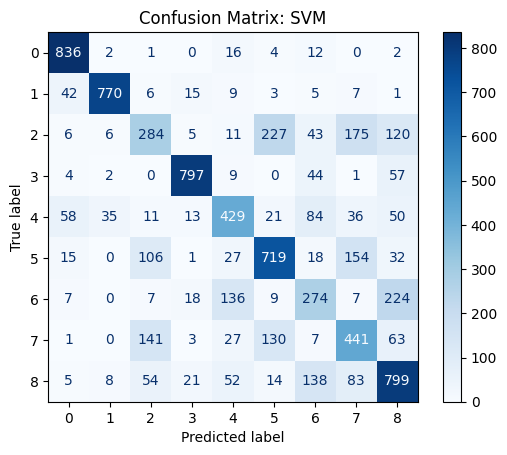

In [ ]:
# Plot confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_SVM)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(cmap='Blues')
plt.title("Confusion Matrix: SVM")
plt.show()

### Fully connected neural network

In [ ]:
# Final MLP model hyperparameters
param_grid_mlp_final = {
  "activation": ["relu"],
  "dropout_rate": [0.0],
  "learning_rate": [0.01],
  "units": [256],
  "weight_decay": [1e-3],
  "momentum": [0.5]
}

# Train model
build_MLP_final = partial(build_MLP, param_choices=param_grid_mlp_final)
model_MLP = build_MLP_final(hp)
start = time.time()
history_MLP = model_MLP.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop]
)
runtime_MLP = time.time() - start
print(f"\nTraining time: {runtime_MLP:.4f}")

Epoch 1/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.2454 - loss: 2.6750 - val_accuracy: 0.2866 - val_loss: 2.4718
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.3737 - loss: 2.3227 - val_accuracy: 0.3828 - val_loss: 2.2186
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4036 - loss: 2.1975 - val_accuracy: 0.3781 - val_loss: 2.1567
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4341 - loss: 2.0844 - val_accuracy: 0.4456 - val_loss: 2.0427
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.4615 - loss: 2.0100 - val_accuracy: 0.4903 - val_loss: 1.9040
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4777 - loss: 1.9243 - val_accuracy: 0.4375 - val_loss: 1.9727
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4981 - loss: 1.8598 - val_accuracy: 0.4988 - val_loss: 1.7967
Epoch 8/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5047 - loss: 1.8067 - 

In [ ]:
# Predict and Evaluate
y_pred_MLP = np.argmax(model_MLP.predict(X_test), axis=1)
report_MLP = classification_report(y_test, y_pred_MLP, digits=4)
print("Classification Report:\n", report_MLP)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.7711    0.9416    0.8479       873
           1     0.8819    0.7308    0.7992       858
           2     0.4025    0.3273    0.3610       877
           3     0.5167    0.7943    0.6261       914
           4     0.5875    0.5237    0.5538       737
           5     0.5167    0.5065    0.5115      1072
           6     0.2500    0.0015    0.0029       682
           7     0.3961    0.3284    0.3591       813
           8     0.4625    0.6772    0.5496      1174

    accuracy                         0.5567      8000
   macro avg     0.5317    0.5368    0.5124      8000
weighted avg     0.5347    0.5567    0.5263      8000



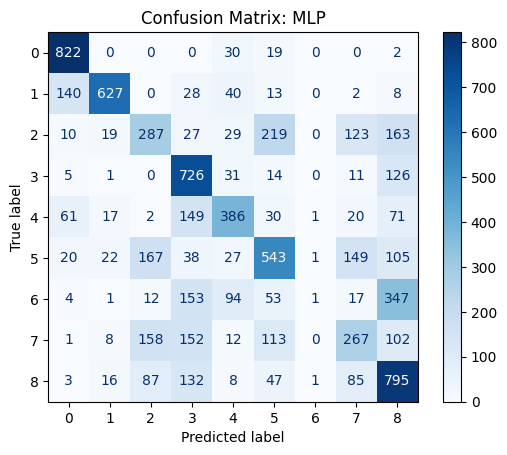

In [ ]:
# Plot confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_MLP)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot(cmap='Blues')
plt.title("Confusion Matrix: MLP")
plt.show()

### Convolutional neural network

In [ ]:
# Final CNN model hyperparameters
param_grid_final = {
    "filters": [32],
    "kernel_size": ["3x3"],
    "pool_size": ["2x2"],
    "stride_size": ["1x1"],
    "dropout_rate": [0.2],
    "learning_rate": [0.001]
}

# Train model
build_CNN_final = partial(build_CNN, param_choices=param_grid_final)
model_CNN = build_CNN_final(hp)
start = time.time()
history_CNN = model_CNN.fit(
    X_train, y_train,
    epochs=15,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop]
)
runtime_CNN = time.time() - start
print(f"\nTraining time: {runtime_CNN:.4f}")

Epoch 1/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.3658 - loss: 1.6840 - val_accuracy: 0.6450 - val_loss: 1.0216
Epoch 2/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.6124 - loss: 1.0313 - val_accuracy: 0.6297 - val_loss: 1.0251
Epoch 3/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.6574 - loss: 0.9317 - val_accuracy: 0.7084 - val_loss: 0.8249
Epoch 4/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6966 - loss: 0.8303 - val_accuracy: 0.7097 - val_loss: 0.8180
Epoch 5/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.7198 - loss: 0.7704 - val_accuracy: 0.7666 - val_loss: 0.7025
Epoch 6/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.7324 - loss: 0.7515 - val_accuracy: 0.7528 - val_loss: 0.6785
Epoch 7/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7577 - loss: 0.6721 - val_accuracy: 0.7559 - val_loss: 0.6853
Epoch 8/15
900/900 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.7699 - loss: 0.6482 - 

In [ ]:
# Predict and Evaluate
y_pred_CNN = np.argmax(model_CNN.predict(X_test), axis=1)
report_CNN = classification_report(y_test, y_pred_CNN, digits=4)
print("Classification Report:\n", report_CNN)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
               precision    recall  f1-score   support

           0     0.9406    0.9622    0.9513       873
           1     0.9404    0.9744    0.9571       858
           2     0.6200    0.7571    0.6817       877
           3     0.9646    0.9551    0.9599       914
           4     0.8183    0.7883    0.8030       737
           5     0.7327    0.8106    0.7697      1072
           6     0.8292    0.5836    0.6850       682
           7     0.6423    0.5412    0.5874       813
           8     0.8417    0.8467    0.8442      1174

    accuracy                         0.8119      8000
   macro avg     0.8144    0.8021    0.8044      8000
weighted avg     0.8147    0.8119    0.8100      8000



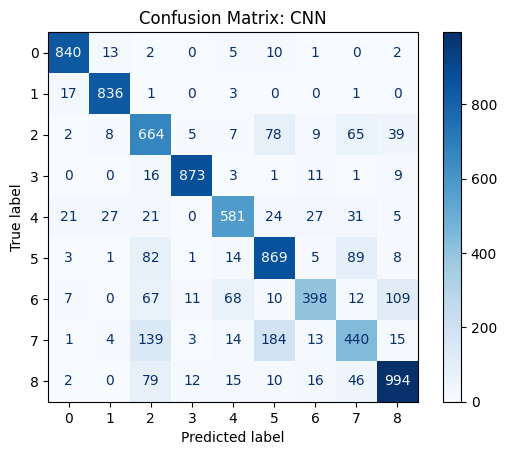

In [ ]:
# Plot confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_CNN)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn)
disp_cnn.plot(cmap='Blues')
plt.title("Confusion Matrix: CNN")
plt.show()